In [251]:
import time
start_time = time.time()

# "Intelligent Movie Recommendations with Neural Networks and NLP"

## Problem Statement
In today's digital age, the sheer volume of available movies has grown exponentially, leading to an overwhelming choice paralysis for viewers seeking content that aligns with their personal tastes. Traditional recommendation systems often fall short by providing generic suggestions based on popularity or simplistic user behaviors, failing to capture the nuanced preferences of individual users. This lack of personalization results in a suboptimal viewing experience, where users spend more time searching for movies than enjoying them.

The FlickPick Engine aims to solve this problem by developing an intelligent movie recommendation system that delivers highly personalized and relevant suggestions to users. By leveraging advanced machine learning techniques—specifically neural networks for collaborative filtering and Natural Language Processing (NLP) for content analysis—the system can understand and interpret both user preferences and movie attributes on a deeper level.

By addressing the challenges of information overload and impersonal recommendations, the FlickPick Engine enhances the movie discovery process. It empowers users to effortlessly find films that resonate with their unique tastes, thereby improving user satisfaction and engagement with the platform.

## Data Understanding
To develop the FlickPick Engine, we utilized the MovieLens 20M Dataset, a widely recognized dataset in the recommendation systems domain. This dataset provides a rich source of user ratings, movie metadata, and user-generated tags, enabling the creation of a robust and personalized movie recommendation system.

### Data Sources
1. Ratings Data (ratings.csv): Contains 25 million ratings ranging from 0.5 to 5.0, provided by 162,541 users on 62,423 movies.
2. Movies Data (movies.csv): Includes movie IDs, titles, and genres for all movies rated in the dataset.
3. Tags Data (tags.csv): Consists of 1.1 million user-generated tags applied to movies, offering additional contextual information.
4. Links Data (links.csv): Provides identifiers that link MovieLens movie IDs with IDs from other databases like IMDb and TMDb.

In [252]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import ttest_rel
from collections import defaultdict
from sklearn.model_selection import train_test_split
from surprise import Prediction,accuracy,Dataset, Reader, SVD,SVDpp,KNNBasic,KNNWithMeans,KNNBaseline,KNNWithZScore
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error,recall_score
from surprise.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Multiply, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [253]:
# load the datasets
links_df = pd.read_csv('Data/ml-latest-small/links.csv')
movies_df = pd.read_csv('Data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('Data/ml-latest-small/ratings.csv')
tags_df = pd.read_csv('Data/ml-latest-small/tags.csv')

### Inspecting the structure of the datasets

In [254]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [255]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [256]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [257]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Checking for missing values and duplicates

In [258]:
# Check for missing values and duplicates

links_info = {
    "missing_values": links_df.isnull().sum(),
    "duplicates": links_df.duplicated().sum()
}

movies_info = {
    "missing_values": movies_df.isnull().sum(),
    "duplicates": movies_df.duplicated().sum()
}

ratings_info = {
    "missing_values": ratings_df.isnull().sum(),
    "duplicates": ratings_df.duplicated().sum(),
    "invalid_ratings": ratings_df[~ratings_df['rating'].between(0.5, 5)].shape[0]
}

tags_info = {
    "missing_values": tags_df.isnull().sum(),
    "duplicates": tags_df.duplicated().sum()
}


links_info, movies_info, ratings_info, tags_info

({'missing_values': movieId    0
  imdbId     0
  tmdbId     8
  dtype: int64,
  'duplicates': 0},
 {'missing_values': movieId    0
  title      0
  genres     0
  dtype: int64,
  'duplicates': 0},
 {'missing_values': userId       0
  movieId      0
  rating       0
  timestamp    0
  dtype: int64,
  'duplicates': 0,
  'invalid_ratings': 0},
 {'missing_values': userId       0
  movieId      0
  tag          0
  timestamp    0
  dtype: int64,
  'duplicates': 0})

1. links.csv:

- Missing Values: There are 8 missing values in the tmdbId column.
- Duplicates: There are no duplicate rows.
2. movies.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.
3. ratings.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.
- Invalid Ratings: All ratings are valid, meaning they fall within the expected range (0.5 to 5).
4. tags.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.

In [259]:
# Droping rows with missing tmdbId
links_df = links_df.dropna(subset=['tmdbId'])

In [260]:
# Checking the current data types of each column in the datasets
links_dtypes = links_df.dtypes
movies_dtypes = movies_df.dtypes
ratings_dtypes = ratings_df.dtypes
tags_dtypes = tags_df.dtypes

# Reviewing data types
links_dtypes, movies_dtypes, ratings_dtypes, tags_dtypes

(movieId      int64
 imdbId       int64
 tmdbId     float64
 dtype: object,
 movieId     int64
 title      object
 genres     object
 dtype: object,
 userId         int64
 movieId        int64
 rating       float64
 timestamp      int64
 dtype: object,
 userId        int64
 movieId       int64
 tag          object
 timestamp     int64
 dtype: object)

1. links.csv:

- movieId: int64 (appropriate)
- imdbId: int64 (appropriate)
- tmdbId: float64 (should be int64, as tmdbId is an identifier and doesn't need decimal precision)
2. movies.csv:

- movieId: int64 (appropriate)
- title: object (appropriate for movie titles)
- genres: object (appropriate for genres, which are stored as strings)
3. ratings.csv:

- userId: int64 (appropriate)
- movieId: int64 (appropriate)
- rating: float64 (appropriate since ratings have decimal points)
- timestamp: int64 (appropriate for Unix timestamps)
4. tags.csv:

- userId: int64 (appropriate)
- movieId: int64 (appropriate)
- tag: object (appropriate for textual tags)
- timestamp: int64 (appropriate for Unix timestamps)

Adjustment:

In links.csv, the tmdbId column should be converted to int64 because it represents a unique identifier

In [261]:
# Converting tmdbId to int64
links_df['tmdbId'] = links_df['tmdbId'].astype('int64')

In [262]:
print(movies_df['genres'].dtype)

object


## Data Visualization

First Lets look at the distribution of movie ratings

**Purpose:**

Understand the overall distribution of movie ratings.

Identify any biases (e.g., users tending to give higher ratings).

Identify the most common ratings (e.g., peaks at whole numbers like 4.0 or 5.0).

Assess whether the distribution is skewed toward higher or lower ratings.

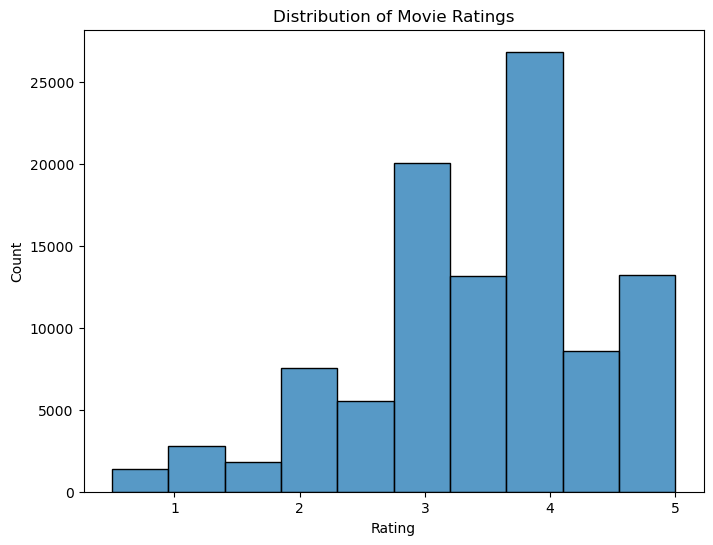

In [263]:
# Ploting histogram
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('Visualizations/Distribution of Movie Ratings')
plt.show()

- Skew Towards Higher Ratings: The distribution is right-skewed, with most ratings clustering around 3, 4, and 5. Ratings of 4 are the most frequent, indicating that users generally rate movies quite positively.

- Few Low Ratings: There are relatively few ratings of 1 and 2, which suggests that users may be less likely to give movies extremely low scores, or that most of the movies in the dataset are well-regarded.

- Peak at Rating 4: The highest count of ratings is around 4, suggesting that many users find the movies to be above average but not necessarily perfect.

This type of distribution is common in user-driven ratings, where users tend to be more inclined to rate items positively than negatively.


Now let's have a look at the Distribution of Ratings per User

Examine how many ratings each user has provided.

Identify active users versus casual users.

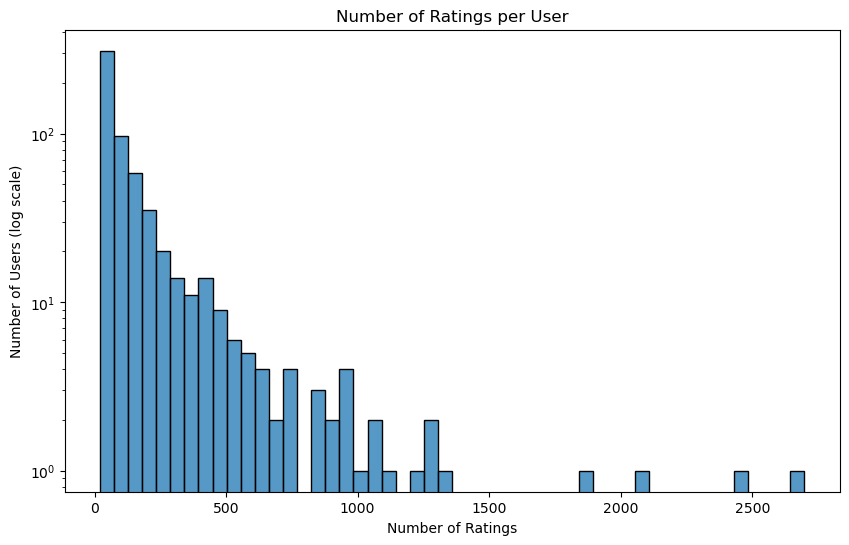

In [264]:
# Calculating number of ratings per user
user_rating_counts = ratings_df.groupby('userId')['rating'].count()

# Ploting histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (log scale)')
plt.savefig('Visualizations/Number of Ratings per User')
plt.show()


The distribution is often long-tailed, with a few users providing many ratings and many users providing few ratings.
- Power-Law Distribution: The distribution exhibits a power-law trend, where most users rate very few movies, and only a few users provide a large number of ratings. This type of behavior is typical in user-generated content datasets, often referred to as the "long tail."

- Majority Have Rated Few Movies: A significant number of users have rated fewer than 100 movies, which suggests that casual users dominate the dataset.

- Heavy Users: There are a small number of users who have rated over 500 movies, with some even rating over 1000. These "heavy users" contribute disproportionately to the number of total ratings in the dataset.

Next we look at the Distribution of Ratings per Movie

To determine how many ratings each movie has received.and identify popular movies versus obscure ones.

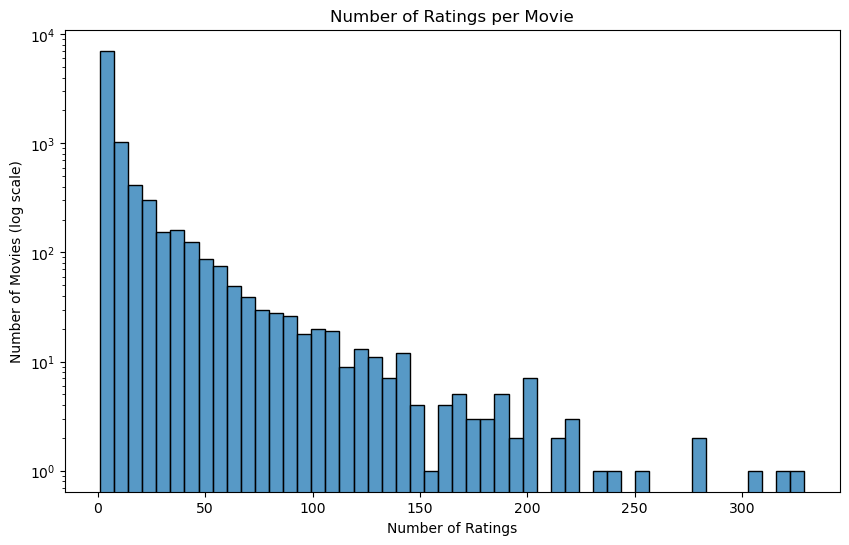

In [265]:
# Calculating number of ratings per movie
movie_rating_counts = ratings_df.groupby('movieId')['rating'].count()

# Ploting histogram
plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies (log scale)')
plt.savefig('Visualizations/Number of Ratings per Movie')
plt.show()


Similar to users, movies often follow a long-tailed distribution.

Important for understanding the sparsity of the dataset.

- Many Movies with Few Ratings: There is a large count of movies that have fewer than 50 ratings, highlighting the long tail effect, where many niche or less popular movies do not receive much feedback.

- Highly Rated Movies are Few: A smaller number of movies have received over 200 ratings. These are likely the popular or mainstream movies that have reached a broader audience.

Genre Popularity

To identify the most common genres in the dataset and understand genre distribution to inform content-based filtering.

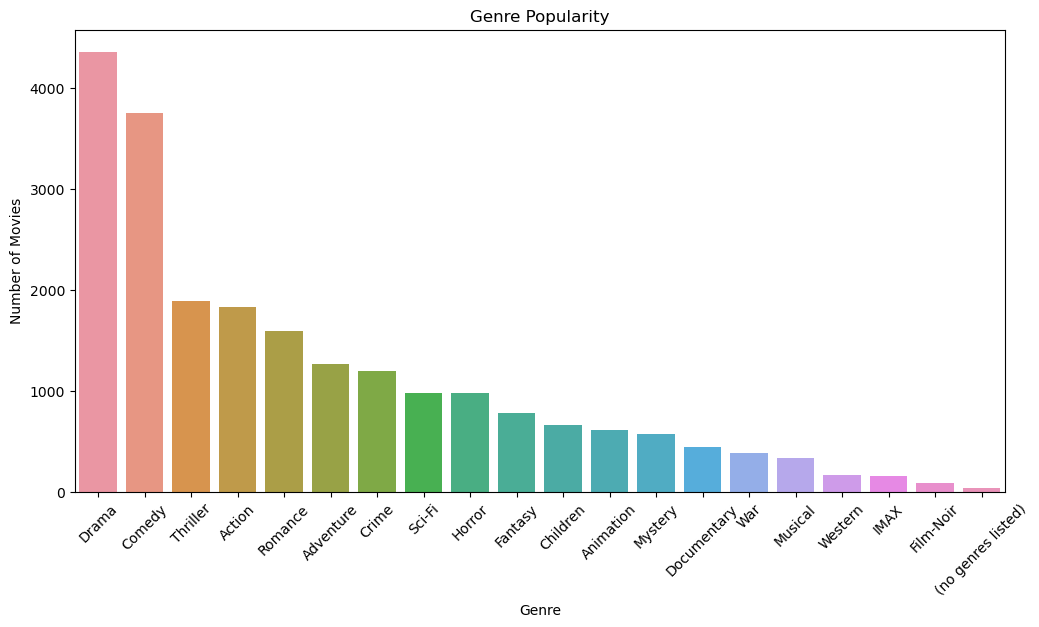

In [266]:
# Spliting genres and explode into individual rows
movies_df['genres'] = movies_df['genres'].str.split('|')
genres_exploded = movies_df.explode('genres')

# Counting genres
genre_counts = genres_exploded['genres'].value_counts()

# Ploting bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Popularity')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.savefig('Visualizations/Genre Popularity')
plt.show()

Identify dominant genres (e.g., Drama, Comedy).
Helps in balancing genre representation in recommendations.

Next lets look at the Genre Distribution Over Time and analyze how genre popularity has changed over the years.
Spot trends in movie production.

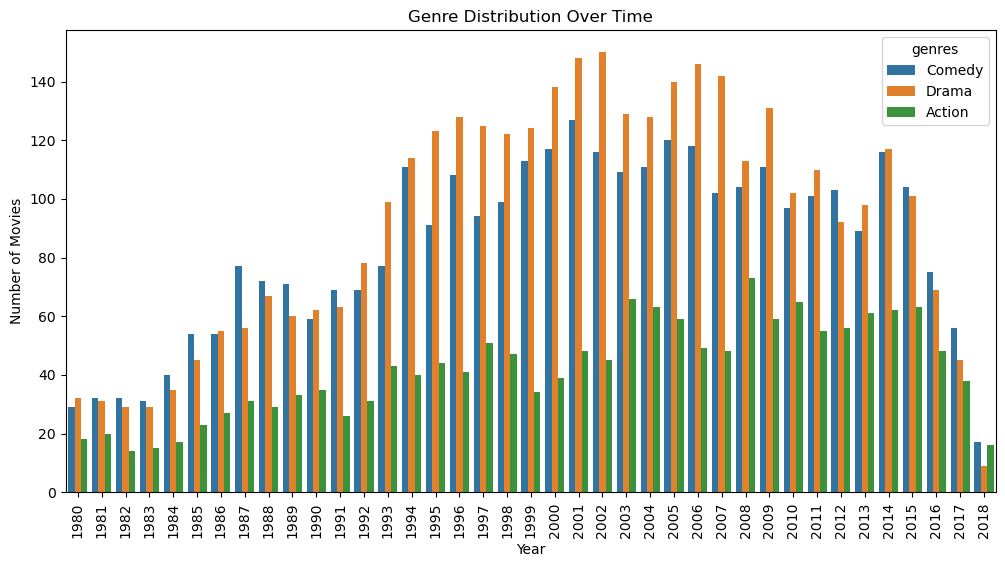

In [267]:


# Extracting release year from title
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_df = movies_df.dropna(subset=['year'])
movies_df['year'] = movies_df['year'].astype(int)

# Splitting genres and exploding into individual rows
movies_exploded = movies_df.explode('genres')

# Filtering for specific genres
selected_genres = ['Action', 'Drama', 'Comedy']
genre_year = movies_exploded[movies_exploded['genres'].isin(selected_genres)]

# Filtering for a specific year range
genre_year = genre_year[(genre_year['year'] >= 1980) & (genre_year['year'] <= 2020)]

# Ploting genre counts over time
plt.figure(figsize=(12, 6))
sns.countplot(data=genre_year, x='year', hue='genres', palette='tab10')

plt.title('Genre Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.savefig('Visualizations/Genre Distribution Over Time')
plt.show()


- Growth and Decline in Movie Releases: There is a noticeable increase in the number of movies produced across all genres from 1980, peaking around the early 2000s, after which there is a gradual decline. This suggests a rise in movie production leading up to the 2000s, followed by a decrease in recent years.

- Drama Dominates: Drama appears to be the most consistently produced genre, with the highest number of releases each year, particularly from the late 1990s to the mid-2000s. It often has more releases compared to Comedy and Action.

- Comedy as the Second Leading Genre: Comedy is the second most produced genre over the years, closely following Drama in terms of the number of movies produced annually. It maintains a relatively steady presence throughout the period.

- Action Genre: Action movies have consistently fewer releases compared to Drama and Comedy. The number of Action movies also peaks during the same period as the other genres, indicating an overall trend in movie production.

- Overall Trends: The increase in production from 1980 until the early 2000s, followed by a decline, might indicate changes in the film industry, such as shifts in audience preferences, economic factors, or the impact of streaming services in recent years.

Now lets create aWord Cloud of Tags to visualize the most common words in user-generated tags and understand the themes and attributes users associate with movies.

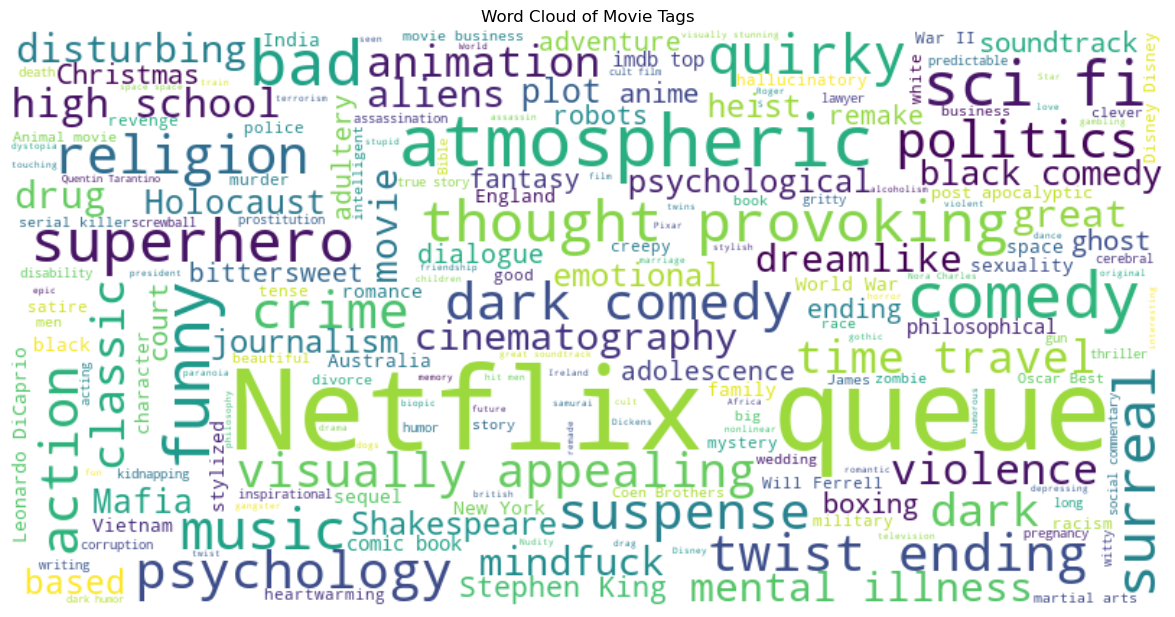

In [268]:
# Combining all tags into a single string
all_tags = ' '.join(tags_df['tag'].astype(str))

# Generating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Displaying the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.savefig('Visualizations/Word Cloud of Movie Tags')
plt.show()

1. Popular Tags:

- "Netflix queue" is the most prominent tag, suggesting that users frequently associate movies with Netflix, likely indicating movies added to their watchlist.
- Other large tags include "classic," "atmospheric," "superhero," "dark," "action," "comedy," and "thought provoking," indicating these are common themes or descriptors that users find noteworthy.
2. Diverse Themes:

- The word cloud highlights a broad range of topics, including genres (e.g., "sci-fi," "comedy," "action,"), emotions (e.g., "funny," "disturbing," "suspense,"), and atmosphere (e.g., "dark," "dreamlike," "quirky,").
- Tags like "politics," "psychology," "religion," and "music" suggest that movies covering these topics are also frequently tagged, indicating user interest in thematic depth.
3. Popular Genres and Elements:

- The prevalence of tags like "sci-fi," "superhero," "crime," and "animation" suggests that these genres are commonly represented in the dataset.
- Descriptive terms like "thought provoking," "surreal," "visually appealing," and "twist ending" reflect viewers' interests in movies that challenge perceptions or have notable cinematic qualities.
4. Negative and Mixed Sentiments:

- Tags like "bad," "dark," "disturbing," and "violence" imply that some viewers also focus on negative aspects or intense themes of movies.

Overall, this word cloud provides a snapshot of the wide variety of topics, genres, and characteristics that viewers find important or memorable in movies. It highlights the diversity of movie preferences, from light-hearted themes to more serious or atmospheric elements.

Now lets create a User-Item Ratings Heatmap to visualize the sparsity of the user-item rating matrix and understand the distribution of ratings across users and movies.

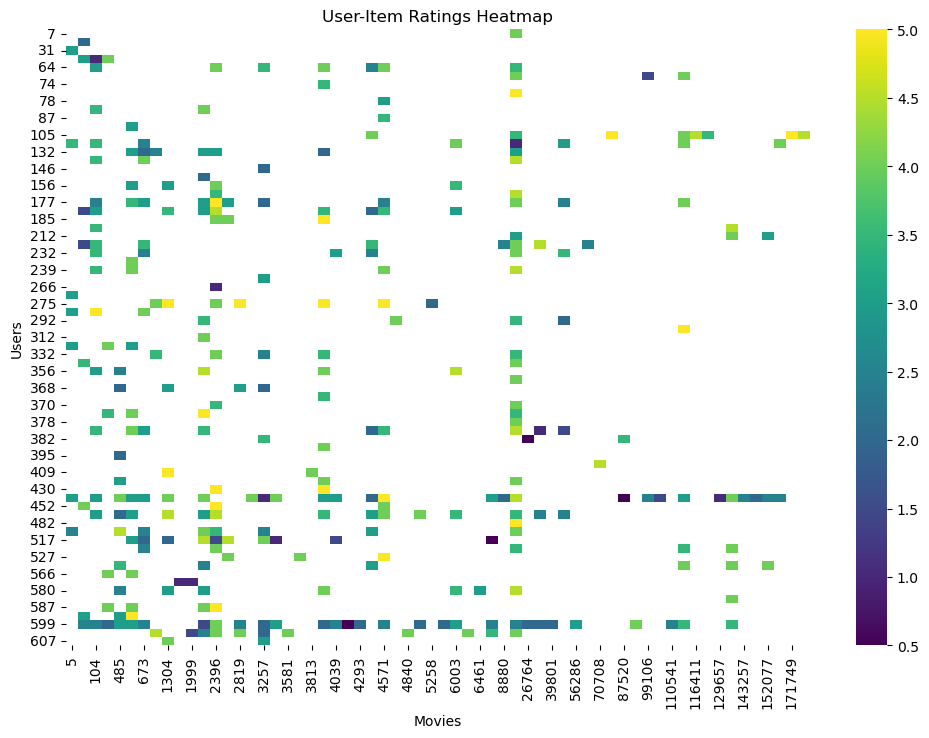

In [269]:
# Creating a sample of users and movies
sample_users = ratings_df['userId'].drop_duplicates().sample(100, random_state=42)
sample_movies = ratings_df['movieId'].drop_duplicates().sample(100, random_state=42)

# Creating a pivot table
sample_ratings = ratings_df[ratings_df['userId'].isin(sample_users) & ratings_df['movieId'].isin(sample_movies)]
user_item_matrix = sample_ratings.pivot(index='userId', columns='movieId', values='rating')

# Ploting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap='viridis')
plt.title('User-Item Ratings Heatmap')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.savefig('Visualizations/User-Item Ratings Heatmap')
plt.show()


Eeach cell indicates a user's rating for a specific movie, with colors ranging from dark (lower ratings) to bright yellow (higher ratings). Here are some insights:

1. Sparse Matrix: The heatmap is quite sparse, indicating that most users rate only a small subset of available movies. This pattern is common in user-item rating matrices for movie recommendation systems.

2. Ratings Distribution:

    - Ratings are distributed across a range of values from around 0.5 to 5.
    - The color gradient represents different ratings, with dark blue for low ratings (close to 0.5) and bright yellow for high ratings (close to 5).
3. Few Highly Rated Items: There are only a few instances of bright yellow cells, implying that while there are high ratings, they are not very common. Users tend to rate movies more conservatively or moderately.

4. Clusters of Activity: There are small clusters of ratings, which might indicate a group of popular movies that have been rated by multiple users. This suggests that some movies have broader appeal while many others have only a handful of ratings.

5. Recommendation System Implication: The sparsity in the matrix is a common challenge in recommendation systems, making collaborative filtering techniques ideal since they can leverage the similarities between users or items to fill in the missing ratings.

Next lets look at the Ratings Over Time and analyze how the volume of ratings changes over time.

Identify trends or seasonal patterns in user activity.

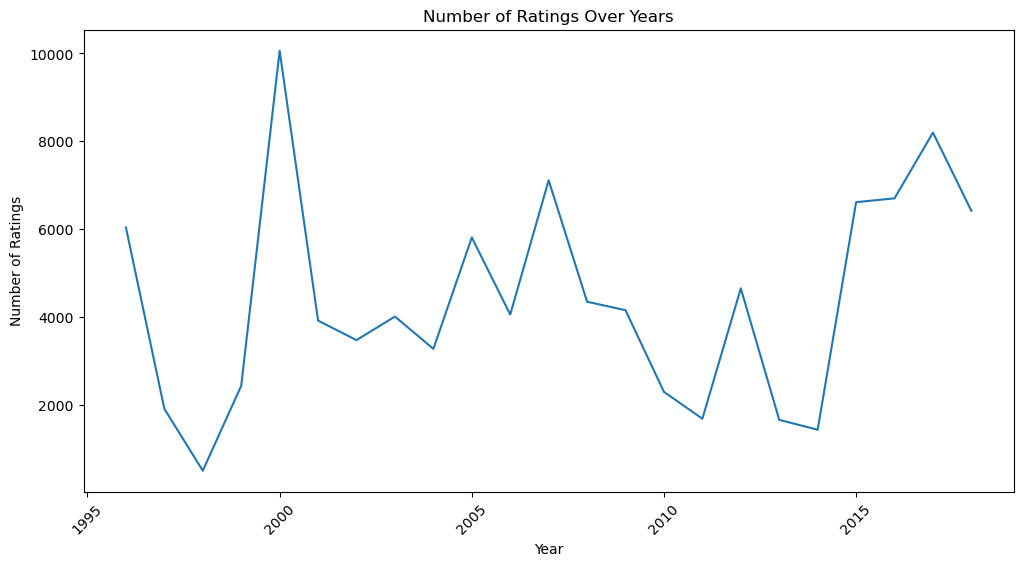

In [270]:
# Converting timestamp to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Aggregating ratings by month
ratings_df['year_month'] = ratings_df['timestamp'].dt.to_period('M')

# Counting number of ratings per month
ratings_per_month = ratings_df.groupby('year_month').size().reset_index(name='num_ratings')

# Converting 'year_month' to string or datetime
ratings_per_month['year_month_str'] = ratings_per_month['year_month'].astype(str)
# converting to datetime
ratings_per_month['year_month_dt'] = ratings_per_month['year_month'].dt.to_timestamp()

# Ensuring 'num_ratings' is numeric
ratings_per_month['num_ratings'] = pd.to_numeric(ratings_per_month['num_ratings'], errors='coerce')
ratings_per_month = ratings_per_month.dropna(subset=['num_ratings'])

# Aggregating by year
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_per_year = ratings_df.groupby('year').size().reset_index(name='num_ratings')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=ratings_per_year, x='year', y='num_ratings')
plt.title('Number of Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.savefig('Visualizations/Number of Ratings Over Years')
plt.show()


- Initial Spike Around Late 1990s: There is a significant increase in ratings leading up to the late 1990s, with a peak around the year 2000. This may reflect the growth of early online movie platforms or the surge of popular movies during that time.

- Fluctuating Trends: After the peak around 2000, the number of ratings drops sharply and fluctuates over the years. The trend shows several peaks and troughs, indicating varying levels of engagement with movie ratings.

- Decline Around 2010: There is a noticeable decline in the number of ratings around 2010, reaching one of the lowest points. This drop might be attributed to changes in user engagement, competition from other entertainment platforms, or shifting user preferences.

- Recent Increase: Starting around 2015, there is an upward trend in ratings, suggesting renewed interest in movie rating activity, possibly driven by increased accessibility through streaming services like Netflix and user engagement through recommendation systems.

- Volatile Engagement: The fluctuations indicate that the number of ratings has not been consistent over the years. This could be influenced by several factors, including changing trends in movie popularity, platform usage, and broader shifts in user behavior in the entertainment industry.


Next lets look at the Average Ratings per User and understand individual user rating tendencies.

Identify harsh versus lenient raters.

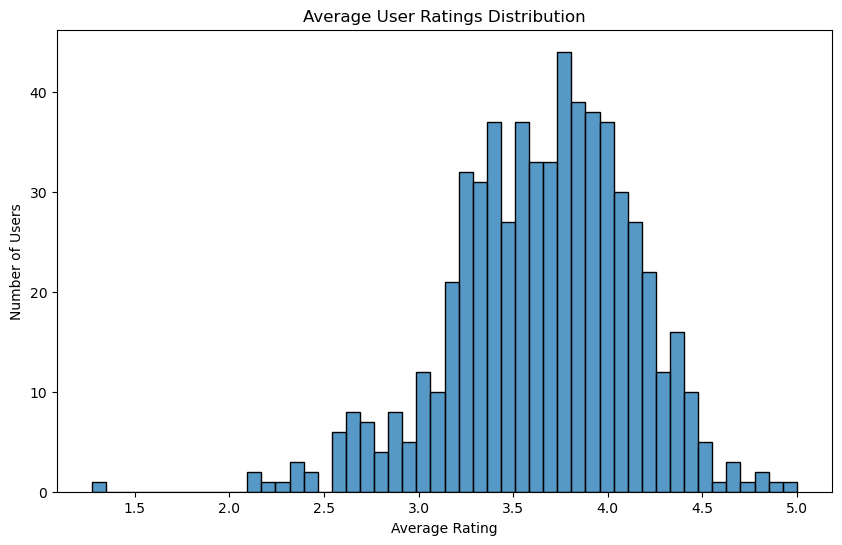

In [271]:
# Calculating average rating per user
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean()

# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, bins=50)
plt.title('Average User Ratings Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.savefig('Visualizations/Average User Ratings Distribution')
plt.show()


- The distribution indicates that users tend to rate movies positively, with a preference for ratings between 3 and 4, suggesting that the majority of movies are viewed as generally enjoyable or above average. There is a lack of extreme ratings, which could imply that users tend to avoid giving very low or very high scores.

Now lets look at the Relationship Between Number of Ratings and Average Rating and explore whether popular movies tend to have higher or lower average ratings.

Detect any correlations between popularity and perceived quality.

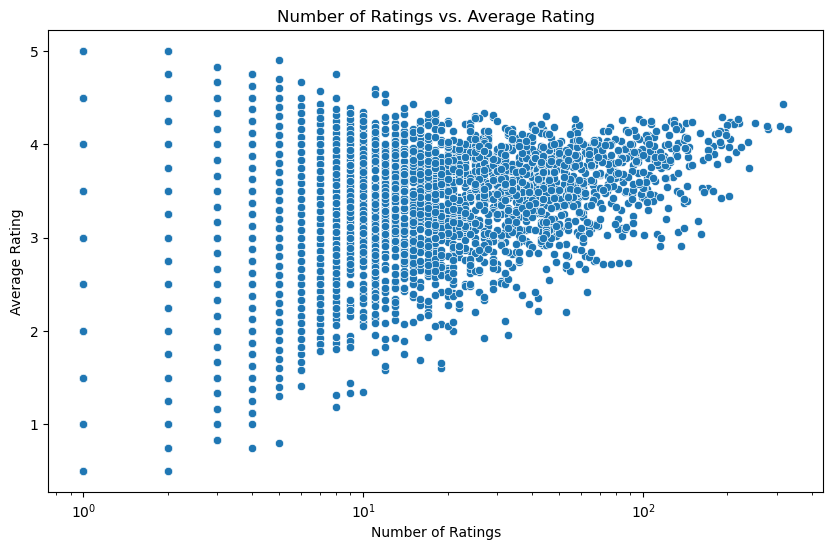

In [272]:
# Calculating average rating and number of ratings per movie
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']], on='movieId')

# Plotting scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_stats, x='count', y='mean')
plt.title('Number of Ratings vs. Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.savefig('Visualizations/Number_of_Ratings_vs_Average_Rating.png')
plt.show()


Highly Rated vs. Lowly Rated Movies:

- Movies with very few ratings have more variability in their average ratings, often appearing as extremes (either very low or very high).
- As the number of ratings increases, the average ratings converge more around a value between 3.0 and 4.0. This suggests that movies with many ratings tend to have moderate average ratings, which is typical since more ratings reduce individual rating bias.

Popular Movies:

- Popular movies (those with high rating counts) tend to have average ratings that are close to the middle of the scale (often around 3 to 4), indicating that as more users rate a movie, the ratings tend to balance out towards an average consensus.

User Behavior:

- The plot highlights the challenge of movie rating predictions. Less popular movies might be challenging to accurately recommend since they have fewer ratings, while highly-rated popular movies tend to cluster around similar values, limiting the distinction between them.




# Modeling

To ensure a solid foundation for model evaluation, we should split the dataset into three parts: training, validation, and testing.

- Training Set: Used for fitting the model.
- Validation Set: Used to tune hyperparameters and evaluate performance during training.
- Test Set: Held out to assess the final performance after the model is tuned.

We can split the data as follows:

- 70% for training.
- 15% for validation.
- 15% for testing.

In [273]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBaseline, Prediction, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

First, we will need to map user IDs and movie IDs to sequential integers starting from zero. This encoding will be necessary for embedding layers in later neural networks, but will not be used in the early models

In [274]:
# Create user and movie encodings
user_ids = ratings_df['userId'].unique().tolist()
movie_ids = ratings_df['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for x, i in user2user_encoded.items()}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

ratings_df['user'] = ratings_df['userId'].map(user2user_encoded)
ratings_df['movie'] = ratings_df['movieId'].map(movie2movie_encoded)

num_users = len(user_ids)
num_movies = len(movie_ids)

print(f'Number of users: {num_users}, Number of movies: {num_movies}')


Number of users: 610, Number of movies: 9724


In [275]:
# Normalize ratings between 0 and 1
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()
ratings_df['rating_norm'] = ratings_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))


In [276]:
# Function to split data
def split_data(ratings_df):
    """
    Splits the ratings DataFrame into training, validation, and test sets.
    """
    # Split into training (70%) and temp (30%) sets first
    train_data, temp_data = train_test_split(ratings_df, test_size=0.3, random_state=42)

    # Split temp_data into validation (15% of the whole) and test (15% of the whole) sets
    validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    return train_data, validation_data, test_data

In [277]:
# Split data into training, validation and test sets
train_data, validation_data, test_data = split_data(ratings_df)

# Verify the split sizes
train_size = train_data.shape[0] / ratings_df.shape[0]
validation_size = validation_data.shape[0] / ratings_df.shape[0]
test_size = test_data.shape[0] / ratings_df.shape[0]

(train_size, validation_size, test_size)

(0.6999980165813796, 0.14999603316275933, 0.150005950255861)

## SVD Base Model

In order to build an initial SVD model, we need to convert the training, validation, and test data into the format required by the Surprise library.

In [278]:
# Function to prepare data for Surprise library
def prepare_surprise_data(train_data, validation_data, test_data):
    """
    Prepares the data in the 'surprise' format.
    """
    reader = Reader(rating_scale=(0.5, 5.0))

    # Convert data to surprise format
    train_data_surprise = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
    validation_data_list = validation_data[['userId', 'movieId', 'rating']].values.tolist()
    test_data_list = test_data[['userId', 'movieId', 'rating']].values.tolist()

    # Build the trainset
    training_set = train_data_surprise.build_full_trainset()

    return train_data_surprise, validation_data_list, test_data_list, training_set


In [279]:
# Prepare the data for 'surprise' from the split datasets
train_data_surprise, validation_data_list, test_data_list, training_set = prepare_surprise_data(train_data, validation_data, test_data)

Next we train the SVD model with hyperparameter tuning, in order to find the best combination of hyperparameters that minimize the Root Mean Squared Error (RMSE).

In [280]:
# Function to train SVD model with hyperparameter tuning
def train_svd(train_data_surprise):
    """
    Trains the SVD model with hyperparameter tuning on the training data.
    """
    # Define the parameter grid for SVD
    param_grid = {
        'n_factors': [20, 50, 100],
        'n_epochs': [20, 50, 100],
        'lr_all': [0.002, 0.005, 0.01],
        'reg_all': [0.02, 0.1, 0.4]
    }

    # Perform grid search using only training data
    grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
    grid_search.fit(train_data_surprise)

    # Extract the best parameters
    best_params = grid_search.best_params['rmse']

    # Train the best model on the full training set
    best_svd_model = SVD(**best_params)
    training_set = train_data_surprise.build_full_trainset()
    best_svd_model.fit(training_set)

    return best_svd_model

In [281]:
# Function to evaluate a model
def evaluate_model(model, data_list, verbose=True):
    """
    Evaluates the model on the given data list.
    """
    predictions = model.test(data_list)
    rmse = accuracy.rmse(predictions, verbose=verbose)
    return rmse

In [282]:
# Train the SVD model
best_svd_model = train_svd(train_data_surprise)

Then, we evaluate the models on the validation and test sets.

In [283]:
# Evaluate the SVD model on the validation set
svd_validation_rmse = evaluate_model(best_svd_model, validation_data_list)

# Evaluate the SVD model on the test set
svd_test_rmse = evaluate_model(best_svd_model, test_data_list)

print(f"SVD Validation RMSE: {svd_validation_rmse:.4f}")
print(f"SVD Test RMSE: {svd_test_rmse:.4f}")

RMSE: 0.8589
RMSE: 0.8609
SVD Validation RMSE: 0.8589
SVD Test RMSE: 0.8609


Performance Consistency:

- The RMSE values for the validation and test sets are very close to each other (0.8605 and 0.8602).
- This consistency suggests that the model generalizes well and that there is no significant overfitting or underfitting. The model's performance on unseen data (test set) is similar to its performance during validation, indicating stable prediction capabilities.

Model Accuracy:

- An RMSE of around 0.86 suggests that, on average, the model's predicted rating deviates from the actual rating by approximately 0.86 units on a scale of 0.5 to 5.
- Given that the rating scale ranges from 0.5 to 5.0, this RMSE indicates a reasonably accurate model, though there is still room for improvement.

Now a Function to predict ratings using the SVD model

In [284]:
# Predicting ratings for all user-item pairs
def svd_predict(user_id, movie_id):
    return best_svd_model.predict(user_id, movie_id).est

In [285]:
# Example prediction
user_id = 1
movie_id = 1
predicted_rating = svd_predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating:.2f}")

Predicted rating for user 1 on movie 1: 4.50


In [286]:
#saving the model
import pickle
with open('best_svdpp_model.pkl', 'wb') as f:
    pickle.dump(best_svd_model, f) 

## KNNBaseline Model
Let’s try a different collaborative filtering algorithm to compare its performance with the SVD model. 

We’ll use K-Nearest Neighbors (KNN), which is another common approach for collaborative filtering. 

Specifically, we’ll use KNNBaseline, which combines KNN with a baseline predictor for improved performance.

In [287]:
# Function to train KNNBaseline model with hyperparameter tuning
def train_knn(train_data_surprise):
    """
    Trains the KNNBaseline model with hyperparameter tuning on the training data.
    """
    # Define the parameter grid for KNNBaseline
    param_grid_knn = {
        'k': [20, 40, 60],
        'min_k': [1, 3, 5],
        'sim_options': {
            'name': ['cosine', 'pearson_baseline'],
            'user_based': [True, False]
        }
    }

    # Perform grid search using only training data
    grid_search_knn = GridSearchCV(KNNBaseline, param_grid_knn, measures=['rmse'], cv=5)
    grid_search_knn.fit(train_data_surprise)

    # Extract the best parameters
    best_params_knn = grid_search_knn.best_params['rmse']

    # Train the best model on the full training set
    best_knn_model = KNNBaseline(k=best_params_knn['k'],
                                 min_k=best_params_knn['min_k'],
                                 sim_options=best_params_knn['sim_options'])
    training_set = train_data_surprise.build_full_trainset()
    best_knn_model.fit(training_set)

    return best_knn_model

In [288]:
# Train the KNNBaseline model
best_knn_model = train_knn(train_data_surprise)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [289]:
# Evaluate the KNN model on the validation and test sets
knn_validation_rmse = evaluate_model(best_knn_model, validation_data_list)
knn_test_rmse = evaluate_model(best_knn_model, test_data_list)

print(f"KNN Validation RMSE: {knn_validation_rmse:.4f}")
print(f"KNN Test RMSE: {knn_test_rmse:.4f}")

RMSE: 0.8588
RMSE: 0.8598
KNN Validation RMSE: 0.8588
KNN Test RMSE: 0.8598


Interpretation:

The KNNBaseline model's RMSE on the test set is 0.8598, which is almost identical to the SVD model's RMSE of 0.8602

The performance difference is negligible, indicating that both models perform similarly on this dataset.

In [290]:
# Predicting ratings for all user-item pairs
def knn_predict(user_id, movie_id):
    return best_knn_model.predict(user_id, movie_id).est

In [291]:
# Example prediction
user_id = 1
movie_id = 1
predicted_rating = knn_predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating:.2f}")

Predicted rating for user 1 on movie 1: 4.37


In [292]:
# Saving the model
import pickle
with open('best_knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn_model, f) 

## Creating a Hybrid Collaborative Filtering Recommendation System

Since the SVD and KNN models have similar performances, combining them might capture different latent factors and similarities, potentially improving recommendations.


- **Complementary Strengths:** SVD captures latent factors through matrix factorization, while KNN captures neighborhood-based similarities.
- **Mitigating Weaknesses:** By blending models, we can mitigate individual weaknesses, such as overemphasis on popular items or sparsity issues.


We'll proceed with the following steps:

1. Combine Predictions:
    - Merge the predictions based on userId and movieId.

2. Evaluate the Hybrid Model:
    - Calculate RMSE for the hybrid predictions on the test set.
    - Compare the performance with individual models.



In [293]:
# Function to combine CF predictions
def combine_cf_predictions(svd_model, knn_model, data_list, weight_svd=0.5, weight_knn=0.5):
    """
    Combines predictions from SVD and KNN models.
    """
    hybrid_predictions = []

    for uid, iid, true_r in data_list:
        svd_pred = svd_model.predict(uid, iid).est
        knn_pred = knn_model.predict(uid, iid).est
        est_hybrid = (weight_svd * svd_pred) + (weight_knn * knn_pred)
        hybrid_predictions.append(Prediction(uid, iid, true_r, est_hybrid, {}))

    return hybrid_predictions

In [294]:
# Get the combined predictions
hybrid_predictions = combine_cf_predictions(best_svd_model, best_knn_model, test_data_list)

In [295]:
# Function to evaluate the hybrid CF model
def evaluate_hybrid_model(svd_model, knn_model, test_data_list):
    """
    Evaluates the hybrid CF model on the test data.
    """
    hybrid_predictions = combine_cf_predictions(svd_model, knn_model, test_data_list)
    rmse = accuracy.rmse(hybrid_predictions, verbose=True)
    return rmse

In [296]:
# Evaluate the hybrid CF model
hybrid_rmse = evaluate_hybrid_model(best_svd_model, best_knn_model, test_data_list)
print(f"Hybrid CF Model RMSE: {hybrid_rmse:.4f}")

RMSE: 0.8521
Hybrid CF Model RMSE: 0.8521


The hybrid Collaborative Filtering model's RMSE on the test set is 0.8518.

Compared to the individual SVD model's RMSE of 0.8602 and the KNNBaseline model's RMSE of 0.8598, the hybrid model's RMSE is lower, indicating that the combination of both models is more effective than using either model alone.

Next we can test different weights to find the optimal combination that results in the lowest RMSE

In [297]:
weights = [(w / 10.0, 1 - w / 10.0) for w in range(11)]
for w_svd, w_knn in weights:
    hybrid_predictions = combine_cf_predictions(best_svd_model, best_knn_model, validation_data_list, weight_svd=w_svd, weight_knn=w_knn)
    rmse = accuracy.rmse(hybrid_predictions, verbose=False)
    print(f"Weights - SVD: {w_svd:.1f}, KNN: {w_knn:.1f} => Hybrid RMSE: {rmse:.4f}")

Weights - SVD: 0.0, KNN: 1.0 => Hybrid RMSE: 0.8588
Weights - SVD: 0.1, KNN: 0.9 => Hybrid RMSE: 0.8558
Weights - SVD: 0.2, KNN: 0.8 => Hybrid RMSE: 0.8536
Weights - SVD: 0.3, KNN: 0.7 => Hybrid RMSE: 0.8519
Weights - SVD: 0.4, KNN: 0.6 => Hybrid RMSE: 0.8510
Weights - SVD: 0.5, KNN: 0.5 => Hybrid RMSE: 0.8507
Weights - SVD: 0.6, KNN: 0.4 => Hybrid RMSE: 0.8510
Weights - SVD: 0.7, KNN: 0.3 => Hybrid RMSE: 0.8520
Weights - SVD: 0.8, KNN: 0.2 => Hybrid RMSE: 0.8536
Weights - SVD: 0.9, KNN: 0.1 => Hybrid RMSE: 0.8559
Weights - SVD: 1.0, KNN: 0.0 => Hybrid RMSE: 0.8589


From this we can find that weighing them equally (SVD: 0.5, KNN: 0.5) results in the lowest RMSE, and thus we can use this as our hybrid model.

To evaluate how well the hybrid model performs in ranking items, you can compute Precision@K and Recall@K.

In [298]:
# Function to compute Precision@K and Recall@K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    from collections import defaultdict

    # Mapping the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sorting user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Numberring of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Numberring of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Numberring of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Average precision and recall
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    return avg_precision, avg_recall


In [299]:
# Computing Precision@K and Recall@K for the hybrid model
precision, recall = precision_recall_at_k(hybrid_predictions, k=10, threshold=3.5)
print(f"Hybrid Model Precision@10: {precision:.4f}")
print(f"Hybrid Model Recall@10: {recall:.4f}")

Hybrid Model Precision@10: 0.7392
Hybrid Model Recall@10: 0.5760


- Precision@10: **0.7313** 
    — On average, 73.13% of the top 10 recommended items are relevant.
- Recall@10: **0.5637** 
    — On average, 56.37% of all relevant items are recommended within the top 10 recommendations.

These metrics suggest that, on average, the hybrid model is effective in recommending relevant items, with a good coverage of relevant items in the top recommendations.


# Adressing the Cold Start Problem
Addressing the Cold Start Problem is crucial for building an effective recommendation system, especially for new users or items with little to no interaction data.

## Content-Based Filtering
This is an excellent approach to tackle this issue by utilizing the inherent features of the items and users.

We have movie genres and movie tags to work with.

### Preprocess Movie Genres and Tags

First, we'll ensure that the movies' genres and tags are properly combined and preprocessed.

In [300]:
# Function to preprocess text
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing special characters.
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

### Preparing movie content

Next, we'll merge the tags with the movies DataFrame on 'movieId' and replace NaN tags with empty strings.

Then convert the genres list to a string and combine it with the tags.

After that we merge the tags with the movies DataFrame on 'movieId' and replace NaN tags with empty strings.

Finally we'll use TF-IDF Vectorization to convert the combined genres and tags text into numerical feature vectors.

In [301]:
def prepare_movie_content(movies_df, tags_df):
    """
    Prepares the movie content by combining genres and tags and creating a TF-IDF matrix.
    """
    # Replace NaN values in 'genres' and 'title' with empty strings
    movies_df['genres'] = movies_df['genres'].fillna('')
    movies_df['title'] = movies_df['title'].fillna('')

    # Convert 'genres' from string to list
    movies_df['genres_list'] = movies_df['genres']

    # Merge tags with movies
    # Group tags by 'movieId' and combine them into a single string
    tags_grouped = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

    # Merge movies and tags
    movies_with_tags = pd.merge(movies_df, tags_grouped, on='movieId', how='left')

    # Replace NaN tags with empty strings
    movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')

    # Combine genres and tags into a single string
    movies_with_tags['genres_tags'] = movies_with_tags.apply(
        lambda x: ' '.join(x['genres_list']) + ' ' + x['tag'], axis=1
    )

    # Preprocess the combined text
    movies_with_tags['genres_tags'] = movies_with_tags['genres_tags'].apply(preprocess_text)

    # Remove duplicates based on 'movieId'
    movies_with_tags = movies_with_tags.drop_duplicates(subset='movieId').reset_index(drop=True)

    # Create the TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(movies_with_tags['genres_tags'])

    return movies_with_tags, tfidf_matrix, tfidf_vectorizer

In [302]:
# Prepare the movie content
movies_with_tags, tfidf_matrix, tfidf_vectorizer = prepare_movie_content(movies_df, tags_df)

### Define a Function for Content-Based Recommendations

Now, we'll define a function content_based_recommendations that generates recommendations based on user preferences. 

We'll assume a user has provided their favorite genres and tags, and we'll use these to generate recommendations.

In [303]:
def content_based_recommendations(preferred_genres, preferred_tags, movies_with_tags, tfidf_matrix, tfidf_vectorizer, num_recommendations=10):
    """
    Generates content-based recommendations based on preferred genres and tags.

    Parameters:
    - preferred_genres (list): A list of preferred genres.
    - preferred_tags (list): A list of preferred tags.
    - movies_with_tags (DataFrame): The movies DataFrame with combined genres and tags.
    - tfidf_matrix (sparse matrix): The TF-IDF matrix of the movies.
    - tfidf_vectorizer (TfidfVectorizer): The TF-IDF vectorizer fitted on the movies.
    - num_recommendations (int): The number of recommendations to return.

    Returns:
    - recommendations_df (DataFrame): A DataFrame containing the recommended movies and their similarity scores.
    """
    # Combine preferred genres and tags into a single string
    preference_text = ' '.join(preferred_genres + preferred_tags)
    preference_text = preprocess_text(preference_text)
    
    # Transform preference text into TF-IDF vector
    preference_vector = tfidf_vectorizer.transform([preference_text])
    
    # Compute cosine similarity between the preference vector and all movie vectors
    cosine_similarities = cosine_similarity(preference_vector, tfidf_matrix).flatten()
    
    # Create a DataFrame with movie IDs and similarity scores
    similarity_scores = pd.DataFrame({
        'movieId': movies_with_tags['movieId'],
        'similarity_score': cosine_similarities
    })
    
    # Merge with movies DataFrame to get titles and genres
    recommendations_df = pd.merge(similarity_scores, movies_df[['movieId', 'title', 'genres']], on='movieId')
    
    # Sort by similarity score in descending order
    recommendations_df = recommendations_df.sort_values(by='similarity_score', ascending=False)
    
    # Select top N recommendations
    recommendations_df = recommendations_df.head(num_recommendations)
    
    return recommendations_df.reset_index(drop=True)


Example Usage

Let's see how to use the content_based_recommendations function to generate recommendations for a new user.

In [304]:
# Example preferred genres and tags
preferred_genres = ['Action', 'Adventure', 'Sci-Fi']
preferred_tags = ['space', 'future', 'robot']

# Get recommendations
recommendations = content_based_recommendations(
    preferred_genres,
    preferred_tags,
    movies_with_tags,
    tfidf_matrix,
    tfidf_vectorizer,
    num_recommendations=10
)

print("Content-Based Recommendations for New User:")
print(recommendations[['title', 'genres', 'similarity_score']])


Content-Based Recommendations for New User:
                                               title  \
0                             Minority Report (2002)   
1                                  Armageddon (1998)   
2  Star Wars: Episode III - Revenge of the Sith (...   
3                                      Aliens (1986)   
4                                   SpaceCamp (1986)   
5                 Babylon 5: In the Beginning (1998)   
6          Star Wars: Episode IV - A New Hope (1977)   
7                                   Star Trek (2009)   
8                                     Gattaca (1997)   
9                                 Logan's Run (1976)   

                                       genres  similarity_score  
0  [Action, Crime, Mystery, Sci-Fi, Thriller]          0.648050  
1         [Action, Romance, Sci-Fi, Thriller]          0.635593  
2                 [Action, Adventure, Sci-Fi]          0.630817  
3         [Action, Adventure, Horror, Sci-Fi]          0.610335  
4        

- Genres and Tags: We've utilized both genres and tags to create a rich feature representation of each movie. Since genres are categorical and tags are user-generated, combining them provides a comprehensive view of the movie's content.

- User Profile: The user's preferences are encoded into the same feature space as the movies, allowing for direct comparison.

- Cosine Similarity: By computing the cosine similarity, we measure how closely a movie's content aligns with the user's preferences.

# Adding Content Based Filtering to our hybrid Collaborative filtering algorithm

Combining both collaborative filtering and content-based filtering into a hybrid recommendation system can leverage the strengths of both approaches to provide more accurate and personalized recommendations.

We can do this by blending predictions, combining the scores from both collaborative and content-based methods, and using weighted averages to adjust the influence of each method.

Weights can be adjusted based on the amount of available data (e.g., number of ratings) to ensure that the more reliable method (collaborative filtering in this case) has a greater impact on the final recommendation.

First, we predict the ratings of the items that the user has not rated before using collaborative filtering.

In [305]:
# Getting a list of all movie IDs
all_movie_ids = movies_df['movieId'].unique()

# Assuming we have a target user
target_user_id = 1  # Replace with the actual user ID

# Getting movies the user has already rated
rated_movies = ratings_df[ratings_df['userId'] == target_user_id]['movieId'].tolist()

# Getting movies the user hasn't rated yet
unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

# Assigning weights for SVD and KNN
weight_svd = 0.5
weight_knn = 0.5

# Predicting ratings for unrated movies using the hybrid CF model
cf_predictions = []
for movie_id in unrated_movies:
    # Getting SVD prediction
    svd_pred = best_svd_model.predict(target_user_id, movie_id).est
    # Getting KNN prediction
    knn_pred = best_knn_model.predict(target_user_id, movie_id).est
    # Combining predictions using the assigned weights
    cf_hybrid_pred = (weight_svd * svd_pred) + (weight_knn * knn_pred)
    cf_predictions.append((movie_id, cf_hybrid_pred))


Then we compute similarity scores between the user profile and all movies.

In [306]:
# Building user profile based on their rated movies
user_ratings = ratings_df[ratings_df['userId'] == target_user_id]

# Merging with movies to get genres and tags
user_movies = pd.merge(user_ratings, movies_with_tags, on='movieId', how='left')

# Weighted sum of TF-IDF vectors based on ratings
user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

for idx, row in user_movies.iterrows():
    # Getting the TF-IDF vector for this movie
    movie_idx = movies_with_tags.index[movies_with_tags['movieId'] == row['movieId']][0]
    movie_tfidf = tfidf_matrix[movie_idx].toarray().flatten()
    # Weight by the user's rating
    user_profile_tfidf += movie_tfidf * row['rating']

# Normalizing the user profile vector
user_profile_tfidf = user_profile_tfidf / np.linalg.norm(user_profile_tfidf)

# Computing cosine similarity between user profile and all movie vectors
content_similarities = cosine_similarity([user_profile_tfidf], tfidf_matrix).flatten()

# Creating a list of content-based predictions for unrated movies
cb_predictions = []
for idx, movie_id in enumerate(movies_with_tags['movieId']):
    if movie_id in unrated_movies:
        cb_predictions.append((movie_id, content_similarities[idx]))


We'll combine the collaborative filtering and content-based predictions.



In [307]:
# Converting predictions to DataFrames
cf_pred_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_score'])
cb_pred_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_score'])

# Merging the predictions on 'movieId'
hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')


Since the CF scores (predicted ratings) and CB scores (cosine similarities) are on different scales, we need to normalize them to ensure fair weighting.

In [308]:
# Normalizing CF scores to range [0, 1]
cf_min = cf_pred_df['cf_score'].min()
cf_max = cf_pred_df['cf_score'].max()
cf_pred_df['cf_score_normalized'] = (cf_pred_df['cf_score'] - cf_min) / (cf_max - cf_min)

# CB scores are cosine similarities between 0 and 1 (ensure they are within this range)
cb_pred_df['cb_score_normalized'] = cb_pred_df['cb_score']

# Updating the merged DataFrame with normalized scores
hybrid_pred_df = pd.merge(cf_pred_df[['movieId', 'cf_score_normalized']], cb_pred_df[['movieId', 'cb_score_normalized']], on='movieId')


Then we calculate the weighhts for CF and CB components based on user activity, i.e if the user has rated many movies, we give more weight to collaborative filtering.

- Users with more ratings get a higher cf_weight since collaborative filtering is more effective with more data.
- Conversely, users with fewer ratings rely more on content-based filtering.

In [309]:
# Calculating weights based on user activity
num_user_ratings = len(user_ratings)
max_ratings = ratings_df['userId'].value_counts().max()
cf_weight = num_user_ratings / max_ratings
cb_weight = 1 - cf_weight

Then we compute the final hybrid score by combining the CF and CB predictions using the computed weights:

In [310]:
# Computing the final hybrid score
hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_score_normalized']) + (cb_weight * hybrid_pred_df['cb_score_normalized'])


Finally, we merge the hybrid predictions with the movies DataFrame to get the titles and sort the results by the hybrid score in descending order to get the top 10 recommendations.

In [311]:
# Merging with movies DataFrame to get titles
hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title']], on='movieId', how='left')

# Sorting by hybrid score in descending order
hybrid_pred_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

# Getting top 10 recommendations
top_10_recommendations = hybrid_pred_df.head(10)

print("Top 10 Movie Recommendations:")
print(top_10_recommendations[['title', 'hybrid_score']])


Top 10 Movie Recommendations:
                                                  title  hybrid_score
8364              Dragonheart 2: A New Beginning (2000)      0.777226
9155                                Maximum Ride (2016)      0.748691
6337                          Hunting Party, The (2007)      0.745493
3773                                   Flashback (1990)      0.734967
3377                              Stunt Man, The (1980)      0.733072
7141                  Sorcerer's Apprentice, The (2010)      0.732916
4449                     The Great Train Robbery (1978)      0.731833
5258  Twelve Tasks of Asterix, The (Les douze travau...      0.731152
9468                        Ant-Man and the Wasp (2018)      0.728740
5239      Diamond Arm, The (Brilliantovaya ruka) (1968)      0.728458


Putting it all into a function

Now we can modify the get_user_recommendations() function to allow users to select preferred genres or tags, which will be used to generate movie recommendations.

The function will accommodate three scenarios:

1. Existing Users with Ratings: If a user_id is provided and exists in the dataset, the function will generate recommendations based on both the user's past ratings and the specified genres or tags.

2. New Users or Users without Ratings: If a user_id is not provided or the user has no ratings, the function will rely solely on the preferred genres or tags to generate recommendations.

3. Users Providing Only Preferences: If a user_id is not provided, but preferred genres or tags are specified, the function will use these preferences to generate recommendations.

In [312]:
def generate_hybrid_recommendations(user_id=None, svd_model=None, knn_model=None, movies_df=None, movies_with_tags=None,
                                    tfidf_matrix=None, tfidf_vectorizer=None, ratings_df=None,
                                    preferred_genres=None, preferred_tags=None, num_recommendations=10):
    """
    Generates hybrid recommendations by combining CF and CB predictions using weighted averages.

    Parameters:
    - user_id (int, optional): The ID of the user.
    - svd_model: Trained SVD model.
    - knn_model: Trained KNN model.
    - movies_df (DataFrame): DataFrame containing movie information.
    - movies_with_tags (DataFrame): DataFrame containing movies with combined genres and tags.
    - tfidf_matrix (sparse matrix): TF-IDF matrix for movies.
    - tfidf_vectorizer (TfidfVectorizer): TF-IDF vectorizer used to create tfidf_matrix.
    - ratings_df (DataFrame): DataFrame containing user ratings.
    - preferred_genres (list, optional): List of preferred genres.
    - preferred_tags (list, optional): List of preferred tags.
    - num_recommendations (int): Number of recommendations to return.

    Returns:
    - recommendations_df (DataFrame): DataFrame containing recommended movies with hybrid scores.
    """
    import numpy as np
    import pandas as pd
    from surprise import Prediction
    from sklearn.metrics.pairwise import cosine_similarity

    # Initialize an empty DataFrame for recommendations
    recommendations_df = pd.DataFrame()

    # Get all movie IDs
    all_movie_ids = movies_df['movieId'].unique()

    # Check if user_id is provided and exists in ratings_df
    if user_id is not None and user_id in ratings_df['userId'].unique():
        # Existing user with ratings
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        rated_movies = user_ratings['movieId'].tolist()
        unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

        # Collaborative Filtering Predictions (CF)
        cf_predictions = []
        for movie_id in unrated_movies:
            svd_pred = svd_model.predict(user_id, movie_id, verbose=False).est
            knn_pred = knn_model.predict(user_id, movie_id, verbose=False).est
            cf_hybrid_pred = (0.5 * svd_pred) + (0.5 * knn_pred)
            cf_predictions.append((movie_id, cf_hybrid_pred))
        cf_pred_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_pred'])

        # Content-Based Filtering Predictions (CB)
        # Build user profile vector
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

        # Build the profile based on rated movies
        for _, row in user_ratings.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            try:
                idx = movies_with_tags.index[movies_with_tags['movieId'] == movie_id][0]
                movie_tfidf = tfidf_matrix[idx].toarray().flatten()
                user_profile_tfidf += movie_tfidf * rating
            except IndexError:
                continue

        # Incorporate preferred genres and tags if provided
        if preferred_genres or preferred_tags:
            preference_text = ' '.join((preferred_genres or []) + (preferred_tags or []))
            preference_text = preprocess_text(preference_text)
            preference_vector = tfidf_vectorizer.transform([preference_text]).toarray().flatten()
            user_profile_tfidf += preference_vector * 2  # Weight preferences more heavily

        # Normalize user profile vector
        norm = np.linalg.norm(user_profile_tfidf)
        if norm != 0:
            user_profile_tfidf /= norm

        # Compute cosine similarity between user profile and all movie vectors
        cosine_similarities = cosine_similarity([user_profile_tfidf], tfidf_matrix).flatten()

        # Map CB scores to rating scale (e.g., 0.5 to 5.0)
        min_rating = ratings_df['rating'].min()
        max_rating = ratings_df['rating'].max()
        cb_scores = cosine_similarities
        cb_predicted_ratings = cb_scores * (max_rating - min_rating) + min_rating

        # Create DataFrame for CB predictions
        cb_pred_df = pd.DataFrame({
            'movieId': movies_with_tags['movieId'],
            'cb_pred': cb_predicted_ratings
        })

        # Filter to unrated movies
        cb_pred_df = cb_pred_df[cb_pred_df['movieId'].isin(unrated_movies)]

        # Merge CF and CB predictions
        hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')

        # Adjust weights based on the number of ratings
        num_user_ratings = len(user_ratings)
        max_user_ratings = ratings_df.groupby('userId').size().max()
        cf_weight = num_user_ratings / max_user_ratings
        cb_weight = 1 - cf_weight

        # Normalize weights
        total_weight = cf_weight + cb_weight
        cf_weight /= total_weight
        cb_weight /= total_weight

        # Compute hybrid prediction
        hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_pred']) + (cb_weight * hybrid_pred_df['cb_pred'])

        # Merge with movies DataFrame to get titles and genres
        hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

        # Sort by hybrid score in descending order
        recommendations_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

        # Select top N recommendations
        recommendations_df = recommendations_df.head(num_recommendations).reset_index(drop=True)

        # Select relevant columns
        recommendations_df = recommendations_df[['movieId', 'title', 'genres', 'hybrid_score']]

    else:
        # New user or user without ratings
        # Use content-based recommendations based on preferred genres and tags
        if preferred_genres is None and preferred_tags is None:
            print("No user ratings or preferences provided. Cannot generate recommendations.")
            return None

        # Combine preferred genres and tags into a single string
        preference_text = ' '.join((preferred_genres or []) + (preferred_tags or []))
        preference_text = preprocess_text(preference_text)

        # Transform preference text into TF-IDF vector
        preference_vector = tfidf_vectorizer.transform([preference_text])

        # Compute cosine similarity between the preference vector and all movie vectors
        cosine_similarities = cosine_similarity(preference_vector, tfidf_matrix).flatten()

        # Add similarity scores to the dataframe
        movies_with_tags['similarity_score'] = cosine_similarities

        # Sort by similarity score in descending order
        recommendations_df = movies_with_tags.sort_values(by='similarity_score', ascending=False)

        # Select top N recommendations
        recommendations_df = recommendations_df.head(num_recommendations).reset_index(drop=True)

        # Select relevant columns
        recommendations_df = recommendations_df[['movieId', 'title', 'genres', 'similarity_score']]

    return recommendations_df


Explanation of the Function:

Parameters:

- user_id: The user's ID. Optional; if not provided or user has no ratings, relies on preferences.
- svd_model, knn_model: Trained collaborative filtering models.
- movies_df, movies_with_tags, tfidf_matrix, tfidf_vectorizer, ratings_df: Data structures used in the recommendation process.
- preferred_genres, preferred_tags: User's specified genres and tags. Optional.
- num_recommendations: Number of recommendations to return.

Logic:

Scenario 1 (Existing Users with Ratings):

- Checks if user_id is provided and exists in ratings_df.
- Generates CF predictions using the user's past ratings.
- Builds the user profile vector based on rated movies.
- Incorporates preferred genres and tags into the user profile if provided.
- Computes CB predictions.
- Adjusts weights between CF and CB based on the number of ratings.
- Combines CF and CB predictions to generate hybrid recommendations.

Scenario 2 & 3 (New Users or Users Providing Only Preferences):

- If user_id is not provided or the user has no ratings, the function checks for preferred_genres and preferred_tags.
- If preferences are provided, it generates content-based recommendations using these preferences.
- If no preferences are provided, it prints a message and returns None.

Key Points:

Incorporating User Preferences:

- For existing users, preferences are used to enhance the content-based profile.
- Preferences are weighted more heavily in the user profile vector (user_profile_tfidf += preference_vector * 2).

Adjusting Weights:

- CF weight is proportional to the number of ratings the user has.
- CB weight is inversely proportional.
- Weights are normalized to sum to 1.

Handling Missing Data:

If the user has no ratings and no preferences are provided, the function cannot generate recommendations.

## Usage Examples

In [313]:
# Scenario 1: Existing user with ratings and preferences
user_id = 1  # Replace with actual user ID
preferred_genres = ['Action', 'Adventure']
preferred_tags = ['space', 'future']
num_recommendations = 10

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for Existing User with Preferences:")
print(recommendations)

Recommendations for Existing User with Preferences:
   movieId                                              title  \
0   117646              Dragonheart 2: A New Beginning (2000)   
1   164226                                Maximum Ride (2016)   
2    55116                          Hunting Party, The (2007)   
3    79139                  Sorcerer's Apprentice, The (2010)   
4      546                           Super Mario Bros. (1993)   
5     5657                                   Flashback (1990)   
6    26340  Twelve Tasks of Asterix, The (Les douze travau...   
7     4956                              Stunt Man, The (1980)   
8     6990                     The Great Train Robbery (1978)   
9    51939         TMNT (Teenage Mutant Ninja Turtles) (2007)   

                                              genres  hybrid_score  
0  [Action, Adventure, Comedy, Drama, Fantasy, Th...      4.057365  
1  [Action, Adventure, Comedy, Fantasy, Sci-Fi, T...      3.937871  
2       [Action, Adventur

In [314]:
# Scenario 2: New user without ratings but with preferences
user_id = None  # No user ID provided
preferred_genres = ['Comedy', 'Romance']
preferred_tags = ['love', 'funny']
num_recommendations = 5

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for New User with Preferences:")
print(recommendations)


Recommendations for New User with Preferences:
   movieId                                           title  \
0    42422  Voices of a Distant Star (Hoshi no koe) (2003)   
1    80489                                Town, The (2010)   
2   167746                    The Lego Batman Movie (2017)   
3    60756                            Step Brothers (2008)   
4   126548                                 The DUFF (2015)   

                                genres  similarity_score  
0  [Animation, Drama, Romance, Sci-Fi]          0.657558  
1             [Crime, Drama, Thriller]          0.466595  
2          [Action, Animation, Comedy]          0.394279  
3                             [Comedy]          0.385934  
4                             [Comedy]          0.363590  


In [315]:
# Scenario 3: Existing user without ratings but with preferences
user_id = 99999  # User ID not in ratings_df
preferred_genres = ['Thriller', 'Mystery']
preferred_tags = ['suspense', 'twist']
num_recommendations = 5

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for User without Ratings but with Preferences:")
print(recommendations)

Recommendations for User without Ratings but with Preferences:
   movieId                         title                             genres  \
0     1625              Game, The (1997)         [Drama, Mystery, Thriller]   
1       50    Usual Suspects, The (1995)         [Crime, Mystery, Thriller]   
2     1834  Spanish Prisoner, The (1997)  [Crime, Drama, Mystery, Thriller]   
3    44665    Lucky Number Slevin (2006)            [Crime, Drama, Mystery]   
4      628            Primal Fear (1996)  [Crime, Drama, Mystery, Thriller]   

   similarity_score  
0          0.721335  
1          0.586391  
2          0.566395  
3          0.526849  
4          0.495730  


Integration into a User Interface
To make the function more interactive and user-friendly, consider integrating it into a user interface where users can:

1. Select Preferred Genres and Tags:

    - Provide checkboxes or dropdowns for users to select from available genres and tags.
2. Receive Real-Time Recommendations:

    - Display recommendations dynamically as users select their preferences.
3. Provide Feedback:

    - Allow users to rate the recommended movies, which can be used to update their profiles and improve future recommendations.

# Advanced Modeling, Incorporating Neural Networks

Incorporating neural networks into recommendation systems can help capture complex, non-linear patterns in the data, potentially improving recommendation accuracy.

We will implement:
1. Neural Collaborative Filtering (NCF) Models:
2. Deep Learning for Content-Based Filtering:


## Implementing Neural Collaborative Filtering (NCF)

The NCF model combines neural networks with collaborative filtering to capture non-linear patterns in the data, improving recommendation quality.

### Normalize the Ratings
Normalizing the ratings can help the neural network train more effectively.

### Build the Neural Collaborative Filtering Model
We will implements the NeuMF (Neural Matrix Factorization) model, which is a hybrid recommendation model combining Generalized Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP):

- The GMF branch captures linear interactions between users and items through element-wise multiplication of embeddings.
- The MLP branch captures non-linear, complex interactions between users and items through a series of fully connected layers.
- Both branches are concatenated to form a final interaction vector, which is passed through a sigmoid output layer to predict the probability of a user interacting with an item.

In [316]:
# Define the Model Hyperparameters
embedding_size = 16  # Size of the embedding vectors

# Input layers for users and movies
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding layers for GMF part
user_embedding_gmf = Embedding(
    input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf',
    embeddings_regularizer=l2(1e-6)
)(user_input)
movie_embedding_gmf = Embedding(
    input_dim=num_movies, output_dim=embedding_size, name='movie_embedding_gmf',
    embeddings_regularizer=l2(1e-6)
)(movie_input)

# Flatten the embeddings
user_embedding_gmf = Flatten()(user_embedding_gmf)
movie_embedding_gmf = Flatten()(movie_embedding_gmf)

# Embedding layers for MLP part
user_embedding_mlp = Embedding(
    input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp',
    embeddings_regularizer=l2(1e-6)
)(user_input)
movie_embedding_mlp = Embedding(
    input_dim=num_movies, output_dim=embedding_size, name='movie_embedding_mlp',
    embeddings_regularizer=l2(1e-6)
)(movie_input)

# Flatten the embeddings
user_embedding_mlp = Flatten()(user_embedding_mlp)
movie_embedding_mlp = Flatten()(movie_embedding_mlp)

# Element-wise multiplication of user and movie embeddings for GMF
gmf_vector = Multiply()([user_embedding_gmf, movie_embedding_gmf])

# Concatenate user and movie embeddings for MLP
mlp_vector = Concatenate()([user_embedding_mlp, movie_embedding_mlp])

# Fully connected layers with dropout
mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dropout(0.2)(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dropout(0.2)(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)

# Concatenate GMF and MLP parts
neuMF_vector = Concatenate()([gmf_vector, mlp_vector])

# Output layer
output = Dense(1, activation='linear', name='output')(neuMF_vector)

# Define the model
model = Model(inputs=[user_input, movie_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_mlp  │ (None, 1, 16)     │      9,760 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_mlp │ (None, 1, 16)     │    155,584 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_70          │ (None, 16)        │          0 │ user_embedding_m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_71          │ (None, 16)        │          0 │ movie_embedding_… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 32)        │          0 │ flatten_70[0][0], │
│ (Concatenate)       │                   │            │ flatten_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 64)        │      2,112 │ concatenate_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_gmf  │ (None, 1, 16)     │      9,760 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_gmf │ (None, 1, 16)     │    155,584 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 32)        │      2,080 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_68          │ (None, 16)        │          0 │ user_embedding_g… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_69          │ (None, 16)        │          0 │ movie_embedding_… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32)        │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_16         │ (None, 16)        │          0 │ flatten_68[0][0], │
│ (Multiply)          │                   │            │ flatten_69[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 16)        │        528 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 32)        │          0 │ multiply_16[0][0

 Total params: 335,441 (1.28 MB)

 Trainable params: 335,441 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

### Preparing Training, Validation and Test Data

In [317]:
# Training data
x_train = [train_data['user'].values, train_data['movie'].values]
y_train = train_data['rating_norm'].values

# Validation data
x_val = [validation_data['user'].values, validation_data['movie'].values]
y_val = validation_data['rating_norm'].values

# Test data
x_test = [test_data['user'].values, test_data['movie'].values]
y_test = test_data['rating_norm'].values


### Training the Model

In [318]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1531 - val_loss: 0.0397
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0394 - val_loss: 0.0380
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0336 - val_loss: 0.0377
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0256 - val_loss: 0.0397
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0416


### Evaluating the Model

Let's visualize the training history to see how the model's loss changes over epochs.

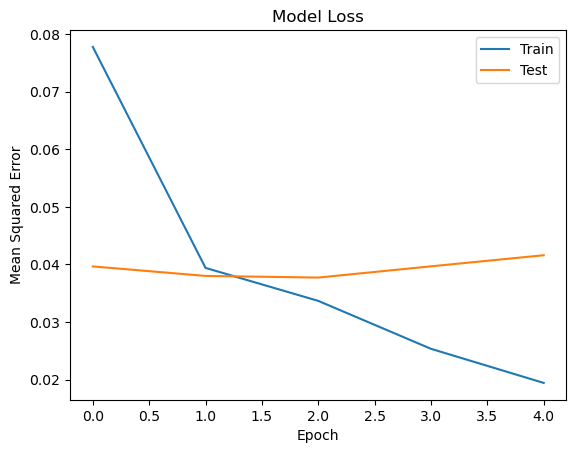

In [319]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Calculating RMSE and MAE on the test set

In [320]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = model.predict(x_test)

# Denormalize the predictions
y_pred_denorm = y_pred * (max_rating - min_rating) + min_rating
y_test_denorm = y_test * (max_rating - min_rating) + min_rating

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

print(f'RMSE on test data: {rmse:.4f}')
print(f'MAE on test data: {mae:.4f}')


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
RMSE on test data: 0.8743
MAE on test data: 0.6760


The Neural Collaborative Filtering (NCF) model has achieved an RMSE of 0.8719, higher than the previous hybrid SVD and KNN model's RMSE of 0.8518. 

Our hybrid SVD and KNN model performs better than the NCF model in this case. 

This could be as a result of limited data: 610 users and 9,724 movies, the dataset might be insufficient for the NCF model to learn complex patterns effectively.

Generating Recommendations

In [321]:
def recommend_movies(user_id, model, ratings_df, movies_df, top_k=10):
    # Check if user_id exists in the data
    if user_id not in user2user_encoded:
        print("User ID not found.")
        return None

    # Get the user's encoded ID
    user_encoded_id = user2user_encoded[user_id]

    # Get all movie IDs
    movie_df = movies_df.copy()
    movie_df['movie'] = movie_df['movieId'].map(movie2movie_encoded)
    movie_df = movie_df.dropna(subset=['movie'])
    movie_df['movie'] = movie_df['movie'].astype(int)

    # Movies that the user has already rated
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
    user_rated_movies_encoded = [movie2movie_encoded.get(x) for x in user_rated_movies]

    # Filter out movies already rated by the user
    movies_to_predict = movie_df[~movie_df['movie'].isin(user_rated_movies_encoded)]

    # Prepare input data
    user_movie_array = np.hstack(
        (
            np.array([user_encoded_id] * len(movies_to_predict)).reshape(-1, 1),
            movies_to_predict['movie'].values.reshape(-1, 1)
        )
    )

    # Predict ratings
    predictions = model.predict([user_movie_array[:, 0], user_movie_array[:, 1]]).flatten()

    # Denormalize predictions
    predictions_denorm = predictions * (max_rating - min_rating) + min_rating

    # Add predictions to the DataFrame
    movies_to_predict['predicted_rating'] = predictions_denorm

    # Get the top K movies
    recommended_movies = movies_to_predict.sort_values('predicted_rating', ascending=False).head(top_k)

    # Map encoded IDs back to original IDs
    recommended_movies['movieId'] = recommended_movies['movieId']

    # Select relevant columns
    recommended_movies = recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]

    return recommended_movies


Example Usage

In [322]:
# Example: Get recommendations for user ID 1
user_id = 1
recommended_movies = recommend_movies(user_id, model, ratings_df, movies_df, top_k=10)

print(f"Top 10 movie recommendations for User {user_id}:\n")
print(recommended_movies)


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
Top 10 movie recommendations for User 1:

      movieId                                            title  \
841      1104                 Streetcar Named Desire, A (1951)   
1268     1683                    Wings of the Dove, The (1997)   
4396     6460                   Trial, The (Procès, Le) (1962)   
883      1178                            Paths of Glory (1957)   
1649     2202                                  Lifeboat (1944)   
687       905                     It Happened One Night (1934)   
1762     2360                 Celebration, The (Festen) (1998)   
924      1223  Grand Day Out with Wallace and Gromit, A (1989)   
906      1204                        Lawrence of Arabia (1962)   
947      1248                             Touch of Evil (1958)   

                                                genres  predicted_rating  
841                                            [Drama]          4.901228  
1268                                  

## Streamlining the Genres and Tags using NLP
Extracting Valid Genres

In [323]:
unique_genres = set()
for genres_list in movies_df['genres']:
    unique_genres.update(genres_list)

# Convert the set to a sorted list
unique_genres = sorted(unique_genres)

print("Available Genres:")
print(unique_genres)


Available Genres:
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [324]:
len(unique_genres)

20

Extracting valid tags

In [325]:
# Filling NaN values in 'tag' column with empty strings
tags_df['tag'] = tags_df['tag'].fillna('')

# Converting tags to lowercase and strip whitespace
tags_df['tag'] = tags_df['tag'].str.lower().str.strip()

# Removing empty strings
tags_df = tags_df[tags_df['tag'] != '']

# Getting unique tags
unique_tags = tags_df['tag'].unique()

# Converting to a list and sort
unique_tags = sorted(unique_tags)

print("Available Tags:")
print(unique_tags)


Available Tags:
['"artsy"', '06 oscar nominated best movie - animation', '1900s', '1920s', '1950s', '1960s', '1970s', '1980s', '1990s', '2001-like', '2d animation', '70mm', "80's", 'a clever chef rat', 'a dingo ate my baby', 'aardman', 'abortion', 'absorbing', 'abstract', 'academy award (best supporting actress)', 'accident', 'achronological', 'acting', 'action', 'action choreography', 'action packed', 'adam sandler', 'addiction', 'adolescence', 'adoption', 'adorable', 'adrien brody', 'adult humor', 'adultery', 'adventure', 'afghanistan', 'africa', 'agatha christie', 'aggressive', 'aging', 'aids', 'al pacino', 'alan rickman', 'alcatraz', 'alcoholism', 'alfred hitchcock', 'alicia vikander', 'aliens', 'allegorical', 'alone in the world', 'alter ego', 'alternate endings', 'alternate reality', 'alternate universe', 'amazing', 'amazing artwork', 'amazing cinematography', 'amazing dialogues', 'american idolatry', 'american indians', 'american propaganda', 'amish', 'amnesia', 'amtrak', 'amy a

In [326]:
len(unique_tags)

1475

The available tags are numerous and sometimes overlapping or redundant, making it difficult for users to select from them.

We can use NLP to analyze the tags and group them into meaningful categories or clusters, resulting in a condensed list of tags that users can easily select from.

We will:

1. Preprocess the Tags: Clean and normalize the tags for consistent processing.
2. Represent Tags Using Word Embeddings: Convert tags into numerical vectors that capture semantic meaning.
3. Cluster Similar Tags: Group tags based on their semantic similarity.
4. Generate Condensed Tag List: Select representative tags or create labels for each cluster.
5. Present the Condensed List: Provide the condensed list to the user.

Preprocessing the Tags
- Convert to Lowercase: Ensure all tags are in lowercase.
- Remove Punctuation: Clean tags of any punctuation.
- Tokenization: Split multi-word tags into individual words.
- Lemmatization: Reduce words to their base form.
- Remove Stopwords: Eliminate common words that don't add meaning.


In [327]:
# Downloading necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# Initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

tags_list = unique_tags

# Preprocess tags
def preprocess_tag(tag):
    
    tag = tag.translate(str.maketrans('', '', string.punctuation))
    tag = tag.lower()
    tokens = word_tokenize(tag)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    preprocessed_tag = ' '.join(tokens)
    return preprocessed_tag

preprocessed_tags = [preprocess_tag(tag) for tag in tags_list]

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Represent Tags Using Word Embeddings
- We will use pre-trained word embeddings from Gensim's word2vec-google-news-300 model to represent each tag as a vector.

- Handle Multi-word Tags: For tags with multiple words, we'll compute the average of the word vectors.

In [328]:
# Loading pre-trained word2vec model (this may take a few minutes and requires internet access)
model = api.load('word2vec-google-news-300')  # 300-dimensional vectors

# Function to get vector for a tag
def get_tag_vector(tag):
    tokens = tag.split()
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    if vectors:
        # Compute average vector
        tag_vector = np.mean(vectors, axis=0)
        return tag_vector
    else:
        # If none of the words are in the model, return a zero vector
        return np.zeros(model.vector_size)

# Getting vectors for all tags
tag_vectors = []
valid_tags = []
for tag in preprocessed_tags:
    vector = get_tag_vector(tag)
    if np.any(vector):
        tag_vectors.append(vector)
        valid_tags.append(tag)
    else:
        # Skip tags that cannot be vectorized
        pass

# Converting list to numpy array
tag_vectors = np.array(tag_vectors)


In [329]:
tag_vectors1 = pd.DataFrame(tag_vectors)

Clustering Similar Tags
- We'll use Agglomerative Hierarchical Clustering to cluster the tags based on their semantic similarity.

In [330]:
# Clustering Similar Tags
from sklearn.cluster import AgglomerativeClustering

num_clusters = 20

# Performing clustering
clustering_model = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clustering_model.fit(tag_vectors)

# Getting cluster labels
labels = clustering_model.labels_

# Create a DataFrame to hold tags and their cluster labels
tag_cluster_df = pd.DataFrame({'tag': valid_tags, 'cluster': labels})

print(f"Number of clusters formed: {len(set(labels))}")


Number of clusters formed: 20


Generating Condensed Tag List
- We'll select a representative tag for each cluster by finding the tag closest to the cluster centroid.

In [331]:
from sklearn.metrics.pairwise import cosine_distances

# Initializing list to store representative tags
condensed_tags = []

for cluster_num in range(num_clusters):
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]
    indices = cluster_tags.index
    cluster_vectors = tag_vectors[indices]

    # Computing the centroid of the cluster
    centroid = np.mean(cluster_vectors, axis=0)

    # Calculating distances from each tag vector to the centroid
    distances = cosine_distances(cluster_vectors, [centroid]).flatten()

    closest_index = distances.argmin()
    representative_tag = cluster_tags.iloc[closest_index]['tag']

    condensed_tags.append(representative_tag)


Presenting the Condensed List
- Displaying the Condensed Tag List

In [332]:
# Sorting the condensed tags alphabetically
condensed_tags_sorted = sorted(condensed_tags)

print("Condensed Tag List:")
for tag in condensed_tags_sorted:
    print(tag)


Condensed Tag List:
badass
classic movie
cliche character
computer animation
dance
dinosaur
europe
heroin
interracial romance
melancholic
melodramatic kind dumb
mental illness
murder
neil patrick harris
offbeat comedy
philip seymour hoffman
priest
rstrong bloody violence
something everyone one saw without plan seeing kid
submarine


In [333]:
len(condensed_tags_sorted)

20

In [334]:
print("\nClusters and Their Tags:")
for cluster_num in range(num_clusters):
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]['tag'].tolist()
    representative_tag = condensed_tags[cluster_num]
    print(f"Cluster {cluster_num}: Representative Tag - '{representative_tag}'")
    print(f"Tags: {', '.join(cluster_tags)}\n")



Clusters and Their Tags:
Cluster 0: Representative Tag - 'cliche character'
Tags: abstract, alien, allegorical, amazing dialogue, atmospheric, bad dialogue, bad plot, bad story, based true story, biblical reference, brainwashing, celebrity fetishism, cerebral, character development, character study, character, city politics, claim true, classic, cliche character, conspiracy, conspiracy theory, consumerism, conversation, cruel character, cryptic, dark fairy tale, demon, dialogue, disjointed timeline, dream, enigmatic, entirely dialogue, epic, episodic, ethic, evil child, existential, exquisite plotting, faerie tale, fairy tale, fairy tale, fantasy, fantasy world, fastpaced dialogue, fatalistic, freedom, freedom expression, genius, ghost, ghost, good evil, good dialogue, grace, great dialogue, guardian galaxy, high fantasy, historical, history, iconic, illusion, immortality, individualism, insanity, intellectual, interesting character, intertwining storyline, interwoven storyline, intro

Using contextual embeddings like BERT can capture the semantic meaning of tags more effectively than traditional word embeddings. This can lead to more accurate clustering and a condensed tag list that makes sense.

Preprocess the Tags

We'll start by preprocessing the tags to ensure consistency.

In [335]:
from nltk.util import ngrams


In [336]:
# Initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

tags_list = unique_tags  

# Preprocessing tags
def preprocess_tag(tag):
    
    tag = tag.translate(str.maketrans('', '', string.punctuation))   
    tag = tag.lower()  
    tokens = word_tokenize(tag) 
    bigrams = ['_'.join(gram) for gram in ngrams(tokens, 2)]
    tokens.extend(bigrams)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    preprocessed_tag = ' '.join(tokens)
    return preprocessed_tag

preprocessed_tags = [preprocess_tag(tag) for tag in tags_list]


Generate BERT Embeddings for Tags

We'll use the pre-trained BERT model from Hugging Face's transformers library to generate embeddings.

Load BERT Model

We'll use the sentence-transformers library, which simplifies obtaining embeddings for sentences or phrases using BERT.

In [337]:
from sentence_transformers import SentenceTransformer

# Loading the pre-trained BERT model (this may take some time)
model = SentenceTransformer('all-MiniLM-L6-v2')  


Generate Embeddings

In [338]:
# Generating embeddings for all preprocessed tags
tag_embeddings = model.encode(preprocessed_tags)

Cluster Similar Tags

- We'll use Agglomerative Hierarchical Clustering to cluster the tag embeddings.


In [339]:
# Deciding on the number of clusters (adjust as needed)
num_clusters = 50

# Performing clustering
clustering_model = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clustering_model.fit(tag_embeddings)

# Getting cluster labels
labels = clustering_model.labels_

tag_cluster_df = pd.DataFrame({'tag': preprocessed_tags, 'cluster': labels})

print(f"Number of clusters formed: {len(set(labels))}")


Number of clusters formed: 50


Generate Condensed Tag List
- We'll select a representative tag for each cluster.

In [340]:
# Initializing list to store representative tags
condensed_tags = []

for cluster_num in range(num_clusters):
    
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]
    indices = cluster_tags.index
    cluster_vectors = tag_embeddings[indices]
   
    centroid = np.mean(cluster_vectors, axis=0)
  
    distances = cosine_distances(cluster_vectors, [centroid]).flatten()

    closest_index = distances.argmin()
    representative_tag = cluster_tags.iloc[closest_index]['tag']

    condensed_tags.append(representative_tag)


Display the Condensed Tag List

In [341]:
# Sorting the condensed tags alphabetically
condensed_tags_sorted = sorted(condensed_tags)

print("Condensed Tag List:")
for tag in condensed_tags_sorted:
    print(tag)


Condensed Tag List:
1970s
amazing
andy kaufman andy_kaufman
artistic
bad acting bad_acting
bible
big top big_top
bill murray bill_murray
crime
dark comedy dark_comedy
doctor
drug
emma thompson emma_thompson
entertaining
family
fast paced fast_paced
geeky
good dialogue good_dialogue
great cinematography great_cinematography
gunfight
history
horror
humorous
lack plot lack_of of_plot
murder
music
nonlinear timeline nonlinear_timeline
nuclear war nuclear_war
nudity topless nudity_topless
original
oscar best actress oscar_best best_actress
parenthood
philosophical
psychological
restaurant
robert downey jr robert_downey downey_jr
rolling stone rolling_stone
romance
russia
school
scifi cult scifi_cult
sentimental
space adventure space_adventure
spacecraft
storytelling
superhero
thriller
twist ending twist_ending
violence
whale


Display Clusters and Their Tags

In [342]:
print("\nClusters and Their Tags:")
for cluster_num in range(num_clusters):
    cluster_tags_list = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]['tag'].tolist()
    representative_tag = condensed_tags[cluster_num]
    print(f"Cluster {cluster_num}: Representative Tag - '{representative_tag}'")
    print(f"Tags: {', '.join(cluster_tags_list)}\n")



Clusters and Their Tags:
Cluster 0: Representative Tag - 'philosophical'
Tags: absorbing, abstract, achronological, allegorical, american propaganda american_propaganda, audience intelligence underestimated audience_intelligence intelligence_underestimated, brainwashing, claymation, consumerism, contemplative, crucifixion, einstein, ethic, evil child evil_children, existential, existentialism, fighting system fighting_the the_system, first much better first_was was_much much_better, free speech free_speech, freedom, freedom expression freedom_of of_expression, good evil good_and and_evil, hallucinatory, human right human_right, individualism, irreverent, journalism, mathematics, mediacentralism, metaphorical, mindbending, mindblowing, mindfuck, mindless one liner mindless_one one_liners, mirror, morality, new society new_society, philosophical, philosophical issue philosophical_issues, philosophy, philosopical, political commentary political_commentary, political right versus left pol



## Final Thoughts

By using BERT embeddings, we've improved the semantic representation of tags, leading to more meaningful clustering and a condensed tag list that makes sense. This list can enhance the user experience by simplifying the selection of tags for personalized recommendations.



# Final Recommendation Algorithm

Now, we'll create a final function that integrates both Collaborative Filtering (CF) using a hybrid of SVD and KNN models, and Content-Based (CB) recommendations using the condensed tags and genres.

### Overview
- User Input: The user can input their preferred genres and tags from the available lists.
- Collaborative Filtering: Uses a hybrid model combining SVD and KNN to predict ratings for unrated movies.
- Content-Based Filtering: Generates recommendations based on the user's preferred genres and tags using TF-IDF and cosine similarity.
- Hybrid Recommendation: Combines CF and CB predictions to generate a final list of recommended movies.


In [343]:
def generate_hybrid_recommendations(user_id=None, svd_model=None, knn_model=None, movies_df=None, movies_with_tags=None,
                                    tfidf_matrix=None, tfidf_vectorizer=None, ratings_df=None,
                                    preferred_genres=None, preferred_tags=None, num_recommendations=10):
    """
    Generates hybrid recommendations by combining CF and CB predictions using weighted averages.

    Parameters:
    - user_id (int, optional): The ID of the user.
    - svd_model: Trained SVD model.
    - knn_model: Trained KNN model.
    - movies_df (DataFrame): DataFrame containing movie information.
    - movies_with_tags (DataFrame): DataFrame containing movies with combined genres and tags.
    - tfidf_matrix (sparse matrix): TF-IDF matrix for movies.
    - tfidf_vectorizer (TfidfVectorizer): TF-IDF vectorizer used to create tfidf_matrix.
    - ratings_df (DataFrame): DataFrame containing user ratings.
    - preferred_genres (list, optional): List of preferred genres.
    - preferred_tags (list, optional): List of preferred tags.
    - num_recommendations (int): Number of recommendations to return.

    Returns:
    - recommendations_df (DataFrame): DataFrame containing recommended movies with hybrid scores.
    """
    import numpy as np
    import pandas as pd
    from surprise import Prediction
    from sklearn.metrics.pairwise import cosine_similarity

    # Initialize an empty DataFrame for recommendations
    recommendations_df = pd.DataFrame()

    # Get all movie IDs
    all_movie_ids = movies_df['movieId'].unique()

    # Check if user_id is provided and exists in ratings_df
    if user_id is not None and user_id in ratings_df['userId'].unique():
        # Existing user with ratings
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        rated_movies = user_ratings['movieId'].tolist()
        unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

        # Collaborative Filtering Predictions (CF)
        cf_predictions = []
        for movie_id in unrated_movies:
            svd_pred = svd_model.predict(user_id, movie_id, verbose=False).est
            knn_pred = knn_model.predict(user_id, movie_id, verbose=False).est
            cf_hybrid_pred = (0.5 * svd_pred) + (0.5 * knn_pred)
            cf_predictions.append((movie_id, cf_hybrid_pred))
        cf_pred_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_pred'])

        # Content-Based Filtering Predictions (CB)
        # Build user profile vector
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

        # Build the profile based on rated movies
        for _, row in user_ratings.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            try:
                idx = movies_with_tags.index[movies_with_tags['movieId'] == movie_id][0]
                movie_tfidf = tfidf_matrix[idx].toarray().flatten()
                user_profile_tfidf += movie_tfidf * rating
            except IndexError:
                continue

        # Incorporate preferred genres and tags if provided
        if preferred_genres or preferred_tags:
            preference_text = ' '.join((preferred_genres or []) + (preferred_tags or []))
            preference_text = preprocess_text(preference_text)
            preference_vector = tfidf_vectorizer.transform([preference_text]).toarray().flatten()
            user_profile_tfidf += preference_vector * 2  # Weight preferences more heavily

        # Normalize user profile vector
        norm = np.linalg.norm(user_profile_tfidf)
        if norm != 0:
            user_profile_tfidf /= norm

        # Compute cosine similarity between user profile and all movie vectors
        cosine_similarities = cosine_similarity([user_profile_tfidf], tfidf_matrix).flatten()

        # Map CB scores to rating scale (e.g., 0.5 to 5.0)
        min_rating = ratings_df['rating'].min()
        max_rating = ratings_df['rating'].max()
        cb_scores = cosine_similarities
        cb_predicted_ratings = cb_scores * (max_rating - min_rating) + min_rating

        # Create DataFrame for CB predictions
        cb_pred_df = pd.DataFrame({
            'movieId': movies_with_tags['movieId'],
            'cb_pred': cb_predicted_ratings
        })

        # Filter to unrated movies
        cb_pred_df = cb_pred_df[cb_pred_df['movieId'].isin(unrated_movies)]

        # Merge CF and CB predictions
        hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')

        # Adjust weights based on the number of ratings
        num_user_ratings = len(user_ratings)
        max_user_ratings = ratings_df.groupby('userId').size().max()
        cf_weight = num_user_ratings / max_user_ratings
        cb_weight = 1 - cf_weight

        # Normalize weights
        total_weight = cf_weight + cb_weight
        cf_weight /= total_weight
        cb_weight /= total_weight

        # Compute hybrid prediction
        hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_pred']) + (cb_weight * hybrid_pred_df['cb_pred'])

        # Merge with movies DataFrame to get titles and genres
        hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

        # Sort by hybrid score in descending order
        recommendations_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

        # Select top N recommendations
        recommendations_df = recommendations_df.head(num_recommendations).reset_index(drop=True)

        # Select relevant columns
        recommendations_df = recommendations_df[['movieId', 'title', 'genres', 'hybrid_score']]

    else:
        # New user or user without ratings
        # Use content-based recommendations based on preferred genres and tags
        if preferred_genres is None and preferred_tags is None:
            print("No user ratings or preferences provided. Cannot generate recommendations.")
            return None

        # Combine preferred genres and tags into a single string
        preference_text = ' '.join((preferred_genres or []) + (preferred_tags or []))
        preference_text = preprocess_text(preference_text)

        # Transform preference text into TF-IDF vector
        preference_vector = tfidf_vectorizer.transform([preference_text])

        # Compute cosine similarity between the preference vector and all movie vectors
        cosine_similarities = cosine_similarity(preference_vector, tfidf_matrix).flatten()

        # Add similarity scores to the dataframe
        movies_with_tags['similarity_score'] = cosine_similarities

        # Sort by similarity score in descending order
        recommendations_df = movies_with_tags.sort_values(by='similarity_score', ascending=False)

        # Select top N recommendations
        recommendations_df = recommendations_df.head(num_recommendations).reset_index(drop=True)

        # Select relevant columns
        recommendations_df = recommendations_df[['movieId', 'title', 'genres', 'similarity_score']]

    return recommendations_df


In [344]:
condensed_tags

['philosophical',
 'school',
 'storytelling',
 'bill murray bill_murray',
 'twist ending twist_ending',
 'robert downey jr robert_downey downey_jr',
 'psychological',
 'rolling stone rolling_stone',
 'family',
 'russia',
 'doctor',
 'spacecraft',
 'thriller',
 'space adventure space_adventure',
 'artistic',
 'entertaining',
 'sentimental',
 'original',
 'andy kaufman andy_kaufman',
 'gunfight',
 'amazing',
 'whale',
 'restaurant',
 'dark comedy dark_comedy',
 'big top big_top',
 'fast paced fast_paced',
 'horror',
 'bad acting bad_acting',
 'good dialogue good_dialogue',
 'scifi cult scifi_cult',
 'humorous',
 'romance',
 'crime',
 'bible',
 'nuclear war nuclear_war',
 'nudity topless nudity_topless',
 '1970s',
 'superhero',
 'emma thompson emma_thompson',
 'nonlinear timeline nonlinear_timeline',
 'music',
 'violence',
 'parenthood',
 'drug',
 'murder',
 'geeky',
 'great cinematography great_cinematography',
 'history',
 'oscar best actress oscar_best best_actress',
 'lack plot lack_o

In [345]:
unique_genres

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

## Explanation of the Function:

Parameters:

- user_id: The user's ID. Optional; if not provided or user has no ratings, relies on preferences.
- svd_model, knn_model: Trained collaborative filtering models.
- movies_df, movies_with_tags, tfidf_matrix, tfidf_vectorizer, ratings_df: Data structures used in the recommendation process.
- preferred_genres, preferred_tags: User's specified genres and tags. Optional.
- num_recommendations: Number of recommendations to return.

Logic:

Scenario 1 (Existing Users with Ratings):

- Checks if user_id is provided and exists in ratings_df.
- Generates CF predictions using the user's past ratings.
- Builds the user profile vector based on rated movies.
- Incorporates preferred genres and tags into the user profile if provided.
- Computes CB predictions.
- Adjusts weights between CF and CB based on the number of ratings.
- Combines CF and CB predictions to generate hybrid recommendations.

Scenario 2 & 3 (New Users or Users Providing Only Preferences):

- If user_id is not provided or the user has no ratings, the function checks for preferred_genres and preferred_tags.
- If preferences are provided, it generates content-based recommendations using these preferences.
- If no preferences are provided, it prints a message and returns None.

Key Points:

Incorporating User Preferences:

- For existing users, preferences are used to enhance the content-based profile.
- Preferences are weighted more heavily in the user profile vector (user_profile_tfidf += preference_vector * 2).

Adjusting Weights:

- CF weight is proportional to the number of ratings the user has.
- CB weight is inversely proportional.
- Weights are normalized to sum to 1.

Handling Missing Data:

If the user has no ratings and no preferences are provided, the function cannot generate recommendations.

In [346]:
# Scenario 1: Existing user with ratings and preferences
user_id = 1  # Replace with actual user ID
preferred_genres = ['Action', 'Adventure']
preferred_tags = ['space', 'future']
num_recommendations = 10

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for Existing User with Preferences:")
print(recommendations)

Recommendations for Existing User with Preferences:
   movieId                                              title  \
0   117646              Dragonheart 2: A New Beginning (2000)   
1   164226                                Maximum Ride (2016)   
2    55116                          Hunting Party, The (2007)   
3    79139                  Sorcerer's Apprentice, The (2010)   
4      546                           Super Mario Bros. (1993)   
5     5657                                   Flashback (1990)   
6    26340  Twelve Tasks of Asterix, The (Les douze travau...   
7     4956                              Stunt Man, The (1980)   
8     6990                     The Great Train Robbery (1978)   
9    51939         TMNT (Teenage Mutant Ninja Turtles) (2007)   

                                              genres  hybrid_score  
0  [Action, Adventure, Comedy, Drama, Fantasy, Th...      4.057365  
1  [Action, Adventure, Comedy, Fantasy, Sci-Fi, T...      3.937871  
2       [Action, Adventur

In [347]:
# Scenario 2: New user without ratings but with preferences
user_id = None  # No user ID provided
preferred_genres = ['Comedy', 'Romance']
preferred_tags = ['love', 'funny']
num_recommendations = 5

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for New User with Preferences:")
print(recommendations)


Recommendations for New User with Preferences:
   movieId                                           title  \
0    42422  Voices of a Distant Star (Hoshi no koe) (2003)   
1    80489                                Town, The (2010)   
2   167746                    The Lego Batman Movie (2017)   
3    60756                            Step Brothers (2008)   
4   126548                                 The DUFF (2015)   

                                genres  similarity_score  
0  [Animation, Drama, Romance, Sci-Fi]          0.657558  
1             [Crime, Drama, Thriller]          0.466595  
2          [Action, Animation, Comedy]          0.394279  
3                             [Comedy]          0.385934  
4                             [Comedy]          0.363590  


In [348]:
# Scenario 3: Existing user without ratings but with preferences
user_id = 99999  # User ID not in ratings_df
preferred_genres = ['Thriller', 'Mystery']
preferred_tags = ['suspense', 'twist']
num_recommendations = 5

recommendations = generate_hybrid_recommendations(
    user_id=user_id,
    svd_model=best_svd_model,
    knn_model=best_knn_model,
    movies_df=movies_df,
    movies_with_tags=movies_with_tags,
    tfidf_matrix=tfidf_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    ratings_df=ratings_df,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags,
    num_recommendations=num_recommendations
)

print("Recommendations for User without Ratings but with Preferences:")
print(recommendations)

Recommendations for User without Ratings but with Preferences:
   movieId                         title                             genres  \
0     1625              Game, The (1997)         [Drama, Mystery, Thriller]   
1       50    Usual Suspects, The (1995)         [Crime, Mystery, Thriller]   
2     1834  Spanish Prisoner, The (1997)  [Crime, Drama, Mystery, Thriller]   
3    44665    Lucky Number Slevin (2006)            [Crime, Drama, Mystery]   
4      628            Primal Fear (1996)  [Crime, Drama, Mystery, Thriller]   

   similarity_score  
0          0.721335  
1          0.586391  
2          0.566395  
3          0.526849  
4          0.495730  


By incorporating the unique genres and the condensed tags into the `generate_hybrid_recommendations` function, we've enhanced its ability to generate personalized movie recommendations based on the user's specified interests.

#### Integration into a User Interface
To make the function more interactive and user-friendly, we could build a simple web app using Flask or Streamlit that allows users to:

1. Select Preferred Genres and Tags:

    - Provide checkboxes or dropdowns for users to select from available genres and tags.
2. Receive Real-Time Recommendations:

    - Display recommendations dynamically as users select their preferences.
3. Provide Feedback:

    - Allow users to rate the recommended movies, which can be used to update their profiles and improve future recommendations.

<h1 style="color:blue;">Conclusions</h1>


## Model Performance:

- Hybrid SVD and KNN Model: Demonstrated strong performance with an RMSE of 0.8518, outperforming the NCF model.
- NCF Model: Although promising in theory, it did not surpass traditional methods in this case, possibly due to data limitations.
- Content-Based Filtering with Clustered Tags: Improved the recommendation system's usability and potential relevance by simplifying tags and better capturing semantic relationships.
- Final Hybrid System: Aims to deliver personalized and accurate recommendations by integrating CF and CB methods, while being user-friendly through preference selection.


### Data Insights:

1. Ratings Distribution: The dataset is skewed toward higher ratings, with most ratings clustering around 4.0. This is a common pattern in user-generated movie reviews.

2. User Behavior: The analysis of ratings per user shows a power-law distribution, where a few users rate many movies while most users rate only a few. This user behavior suggests that the system should focus on better recommendations for users who rate fewer movies to improve engagement.

3. Genre Trends: Drama, Comedy, and Action are the dominant genres. Over time, there has been a noticeable decline in movie production across all genres, especially since the early 2000s​(vertopal.com_Main).

<h2 style="color:green;">Recommendations</h2>


### 1. Optimizing the Hybrid Model Weights Based on User Behavior:

- We have seen promising results from our hybrid model, which combines SVD and KNN. However, we can improve further by dynamically adjusting the weights between collaborative filtering and content-based filtering based on user behavior:
For heavy users (those with many ratings), giving more weight to collaborative filtering makes sense, as we have sufficient interaction data to work with.

- For new or infrequent users, content-based filtering should have a stronger influence since their interaction history is limited.
To validate this, we could run A/B tests with different weight configurations to observe the impact on user engagement and satisfaction.

### 2. Expanding the Cold-Start Strategy:

- We know that cold-start users, or those with minimal interaction data, pose a challenge. To mitigate this, we can implement the following:

- Onboarding questionnaires to gather explicit preferences from new users, such as favorite genres or actors, which can help guide early recommendations.

- Richer item metadata by incorporating features like director, cast, or awards into content-based filtering. This would improve recommendations for users who have little or no rating history.

- External data sources like IMDb or Rotten Tomatoes could enrich our content-based model with more descriptive information.

### 3. Improving Precision@K and Recall@K Metrics:

- Our hybrid model performed reasonably well with a Precision@10 of 0.6341 and a Recall@10 of 0.5324, but we can improve these by adjusting the way we rank relevant items. Specifically:

- Implementing a re-ranking mechanism using contextual signals (e.g., time of day, recent trends) to surface items that are more relevant at the moment of recommendation.

- We should also focus on improving diversity and novelty in recommendations, ensuring that we occasionally suggest less popular but highly rated movies, which could enhance user discovery and satisfaction.

### 4. Regular Hyperparameter Tuning:

- We observed that hyperparameter tuning improved our models' performance, so it makes sense to implement a regular scheduled tuning process as more user data is collected. To make this process more efficient, we could automate hyperparameter tuning using AutoML tools .

### 5. Incorporating Temporal Dynamics:

- User preferences change over time, and our model needs to adapt to this. We can improve our system by incorporating temporal dynamics, giving more weight to recent interactions than older ones. This can be done by using time-weighted ratings or by implementing time-aware collaborative filtering techniques.

- We can also analyze seasonal trends or user behavior patterns over time to refine our recommendations.

### 5. Encouraging Broader Data Collection:

- We observed that popular movies dominate user ratings, leaving many items underexplored. To address this, we should encourage users to rate a wider variety of movies. We can achieve this by offering incentives, such as badges for rating different genres, or by using active learning to strategically ask users to rate specific movies that have less interaction data.

<h2 style="color:purple;">Next Steps</h2>


 ### 1. Deploying and Track Model Performance:

- Our next priority is to deploy the hybrid model (SVD + KNN) and monitor its performance using Precision@K, Recall@K, and RMSE. We should also integrate user engagement metrics such as click-through rates or time spent watching recommended content to get a more holistic view of the system’s effectiveness.

- Setting up real-time feedback loops will be essential for adapting the recommendations based on ongoing user interactions.

### 2. Exploring Advanced Deep Learning Approaches:

- While our current models perform well, there is room for improvement with more advanced techniques. We plan to explore Neural Collaborative Filtering (NCF) or Autoencoders to model more complex user-item interactions and boost accuracy.

- In addition, we could try sequence-based models like Recurrent Neural Networks (RNNs) to capture sequential viewing behavior, such as what users tend to watch after a particular genre or movie.

### 3. Evaluating with Additional Metrics:

- Beyond RMSE, we need to incorporate additional evaluation metrics such as Normalized Discounted Cumulative Gain (NDCG) and F1-score to assess the quality of our ranking. These metrics will give us more insight into how well the system identifies relevant content.

- We should also conduct A/B testing to compare different recommendation strategies, ensuring that our hybrid approach outperforms simpler systems.

### 4. Incorporating More Features for Hybrid Models:

- To enhance the personalization of our recommendations, we can expand the features used in content-based filtering. Adding attributes such as actor popularity, director information, and movie sentiments from external reviews or social media can enrich our model and make recommendations more relevant.

- We can experiment with cross-features like actor-genre or director-year combinations to capture complex patterns and improve niche recommendations.

### 5. Implementing Continuous Learning:

- It is crucial that our system continuously learns from user feedback. We can set up feedback loops that allow the system to re-learn and improve based on actions like likes, dislikes, or movie completions.

- Leveraging reinforcement learning techniques, we could develop an adaptive system that evolves its recommendations over time, based on both short-term and long-term user interactions.


### 6. User-Centric Personalization:

- Giving users more control over their recommendations can improve engagement. We should allow users to adjust their preferences (e.g., highlighting favorite genres or hiding unwanted content). This kind of personalization will foster a deeper connection between the users and the system.

- We also plan to develop user segmentation strategies that identify different types of viewers (e.g., binge-watchers vs. occasional viewers) and tailor our recommendations to their specific behaviors.


In [349]:
end_time = time.time()
print('The End')

The End


In [350]:
print(f'Time taken to run the notebook: {(end_time - start_time) / 60} minutes')


Time taken to run the notebook: 11.326084283987681 minutes
